In [ ]:
# imports
import pandas as pd
import os

from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout, Input, Activation, Add, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import random 
import numpy as np 

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers

import datetime
from datetime import timedelta

import polars as pl

import seaborn as sns

import data_preprocessing
from data_integration import combine_data, read_data

In [ ]:
"""
    Calls the "read_data()" function from file "data_integration.py"
    Calls the "combine_data()" function from file "data_integration.py"
    Parameter:
    - 1: combines only glucose data
    - 2: combines glucose and dempgraphics
    - 3: combines glucose and heartrate
    Output: This function returns the intrgrated dataset included the restricted databases if downloaded and added to folder "datasets for T1D"
 """
# reads all datasets, if they are stored in the required folder DiaData/datasets for T1D/...
restricted_list = read_data(read_all = True)

In [ ]:
# from all data extracts only subdatabase II 
subdatabaseII = combine_data(3, restricted_list)  

## Outlier detection

In [ ]:
# calls function remove_outliers() for glucose and heart rate columns based on the IQR method
data_cleaned_glc = data_preprocessing.remove_outliers(subdatabaseII, value = "GlucoseCGM", modus = "glucose", subject = "PtID")
data_cleaned = data_preprocessing.remove_outliers(data_cleaned_glc, value = "HR", modus = "vitals", subject = "PtID")  

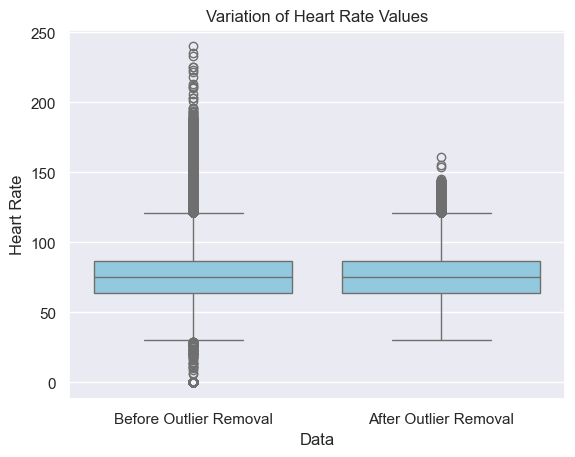

In [ ]:
# prints the boxplots before and after outlier removal
# first the unprocessed data is copied and marked
combi = subdatabaseII.copy()
combi['Data'] = 'Before Outlier Removal'

# then the processed data is copied and marked
df_int = data_cleaned.copy()
df_int['Data'] = 'After Outlier Removal'

# both are combined to the same dataset to enable boxplots next to each other
combined_both = pd.concat([combi, df_int])
combined_both = combined_both.reset_index(drop=True)

# Boxplots grouped by the data type (before or after outlier removal) are plotted 
sns.set_theme(style="darkgrid")
sns.boxplot(x='Data', y='HR', data=combined_both,showfliers=True, color='skyblue')
plt.title('Comparison of Value Distributions')
plt.title("Variation of Heart Rate Values")
plt.suptitle("")  
plt.ylabel("Heart Rate")
plt.show()

## Missing value imputation

In [ ]:
# linear interpolation is used for gaps which are less than 30 minute (6 consecutive datapoints)
# first for glucose then for heart rate values by callign the function gap_limited_interpolation()
df_interpolated = data_cleaned.copy()
df_interpolated['GlucoseCGM'] = df_interpolated.groupby('PtID')['GlucoseCGM'].transform(
    lambda x: data_preprocessing.gap_limited_interpolation(x, limit=6)
)

df_interpolated['HR'] = df_interpolated.groupby('PtID')['HR'].transform(
    lambda x: data_preprocessing.gap_limited_interpolation(x, limit=6)
)

# then gaps between 30 and 120 min are imputed with stine interpolation separately for glucose and heart rate 
df_interpolated_stine = df_interpolated.groupby("PtID", group_keys=False).apply(lambda x: data_preprocessing.interpolate_stineman_group(x, timestamp = "ts", value = "GlucoseCGM", llimit=6, ulimit=24))
# index is sorted 
df_interpolated_stine = df_interpolated_stine.sort_index()
df_interpolated_stine = df_interpolated.groupby("PtID", group_keys=False).apply(lambda x: data_preprocessing.interpolate_stineman_group(x, timestamp = "ts", value = "HR", llimit=6, ulimit=24))
# index is sorted 
df_interpolated_stine = df_interpolated_stine.sort_index()

In [ ]:
# as a comparison, a copy of the cleaned dataset before imputation is made
only_interpolated = data_cleaned.copy()

# missing values of this copy are imputed with linear interpolation for all gaps lengths
only_interpolated['GlucoseCGM'] = only_interpolated.groupby('PtID')['GlucoseCGM'].transform(lambda group: group.interpolate(method='linear'))
only_interpolated['HR'] = only_interpolated.groupby('PtID')['HR'].transform(lambda group: group.interpolate(method='linear'))

/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_2135/1351457704.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_2135/1351457704.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels())


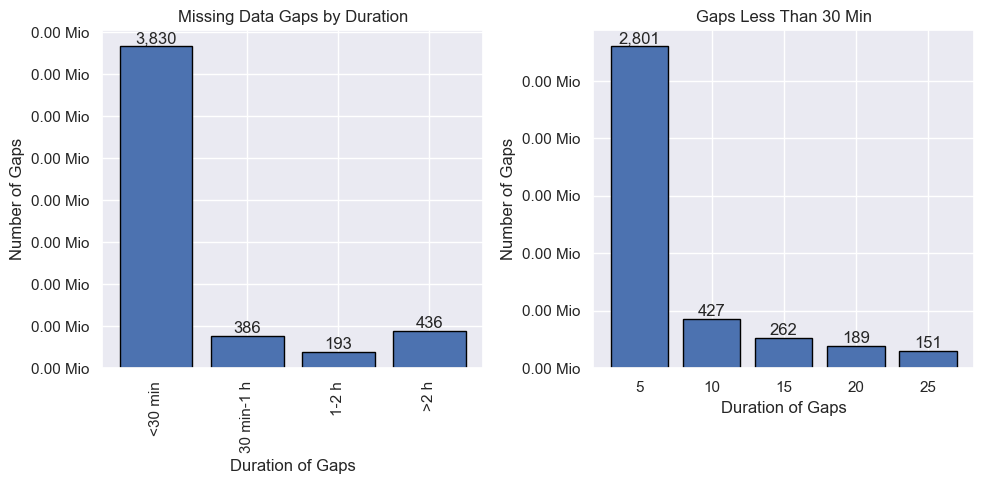

In [ ]:
from matplotlib.ticker import FuncFormatter

# plots missing values to explore the data quality

# function to show both value and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        val_mio = round(val / 1_000_000, 1)
        return f"{val} ({pct:.1f}%)"
    return my_autopct

# the dataframe is copied
df_glc_missing = subdatabaseII.copy()
# first, missing blocks are identified 
df_glc_missing["missing"] = df_glc_missing["HR"].isna()

# uses groupby with cumsum to find continuous blocks
df_glc_missing["gap_id"] = (df_glc_missing["missing"] != df_glc_missing["missing"].shift()).cumsum()
# groups by the identified gaps
na_groups = df_glc_missing[df_glc_missing["missing"]].groupby("gap_id").size().reset_index(name="missing_count")
# one row of missing data equals 5 minutes, so the length of gap is multiplied by 5
na_groups["missing_count_time"] = na_groups["missing_count"] * 5

# categorizes durations based on specified bins and labels
bins = [0,30,60,120,na_groups["missing_count_time"].max()]
labels = [
    "<30 min",
    "30 min-1 h",
    "1-2 h",
    ">2 h"
]
# converts durations to timedelta seconds for binning
duration_bins = pd.cut(na_groups["missing_count_time"], bins=bins, labels=labels, right=False)

# counts number of gaps per duration range
gap_counts = duration_bins.value_counts().sort_index()

# creates the bin groups
na_groups["MissingGroup"] = pd.cut(na_groups["missing_count_time"], bins=bins, labels=labels, right=False)
# filters to only less than 30 minute gaps
count_30_missing = na_groups[na_groups["MissingGroup"] ==  "<30 min"]["missing_count_time"].value_counts()

# plots the missing values count per created group and for the second group of less than 30 minutes in 5 minute intervals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plots the barchart of all missing value groups
ax1.bar(gap_counts.index.astype(str), gap_counts.values, edgecolor="black")
ax1.set_title("Missing Data Gaps by Duration")
ax1.set_xlabel("Duration of Gaps")
ax1.set_ylabel("Number of Gaps")

# formatter function
def millions(x, pos):
    return f"{x*1e-6:.2f} Mio"

# applyies formatter to axis
ax1.yaxis.set_major_formatter(FuncFormatter(millions))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    
for bar in ax1.patches:
    height = bar.get_height()
    label = f"{int(height):,}"  # adds comma separators for readability
    ax1.text(
        bar.get_x() + bar.get_width() / 2,  # center of the bar
        height,                             # top of the bar
        label,                              # text to display
        ha="center", va="bottom"
    )

# plots the missing values distribution less than 30 minutes as a bar chart
ax2.bar(count_30_missing.index.astype(str), count_30_missing.values, width=0.8, edgecolor="black")
ax2.set_title("Gaps Less Than 30 Min")
ax2.set_xlabel("Duration of Gaps")
ax2.set_ylabel("Number of Gaps")

for bar in ax2.patches:
    height = bar.get_height()
    label = f"{int(height):,}"  # adds comma separators for readability
    ax2.text(
        bar.get_x() + bar.get_width() / 2,  # center of the bar
        height,                             # top of the bar
        label,                              # text to display
        ha="center", va="bottom"
    )

# applies formatter to axis 
ax2.yaxis.set_major_formatter(FuncFormatter(millions))
ax2.set_xticklabels(ax2.get_xticklabels())

# layout
plt.tight_layout()
plt.show()

/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_2469/1415765896.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_2469/1415765896.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels())


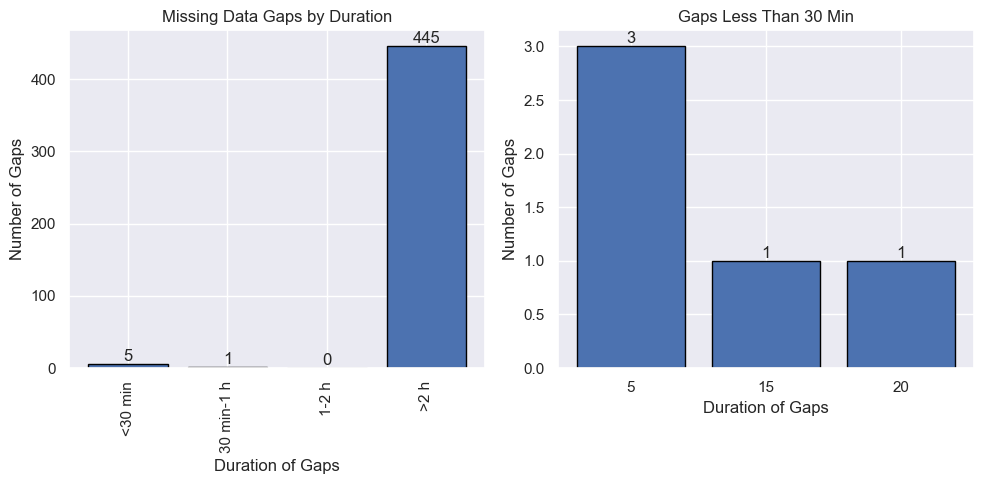

In [ ]:
from matplotlib.ticker import FuncFormatter
# plots missing values to explore the data quality

# function to show both value and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        val_mio = round(val / 1_000_000, 1)
        return f"{val} ({pct:.1f}%)"
    return my_autopct

# the dataframe is copied
df_glc_missing = df_interpolated_stine.copy()
# first, missing blocks are identified 
df_glc_missing["missing"] = df_glc_missing["HR"].isna()

# uses groupby with cumsum to find continuous blocks
df_glc_missing["gap_id"] = (df_glc_missing["missing"] != df_glc_missing["missing"].shift()).cumsum()
# groups by the identified gaps
na_groups = df_glc_missing[df_glc_missing["missing"]].groupby("gap_id").size().reset_index(name="missing_count")
# one row of missing data equals 5 minutes, so the length of gap is multiplied by 5
na_groups["missing_count_time"] = na_groups["missing_count"] * 5

# categorizes durations based on specified bins and labels
bins = [0,30,60,120,na_groups["missing_count_time"].max()]
labels = [
    "<30 min",
    "30 min-1 h",
    "1-2 h",
    ">2 h"
]
# converts durations to timedelta seconds for binning
duration_bins = pd.cut(na_groups["missing_count_time"], bins=bins, labels=labels, right=False)

# counts number of gaps per duration range
gap_counts = duration_bins.value_counts().sort_index()

# creates the bin groups
na_groups["MissingGroup"] = pd.cut(na_groups["missing_count_time"], bins=bins, labels=labels, right=False)
# filters to only less than 30 minute gaps
count_30_missing = na_groups[na_groups["MissingGroup"] ==  "<30 min"]["missing_count_time"].value_counts()

# plots the missing values count per created group and for the second group of less than 30 minutes in 5 minute intervals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plots the barchart of all missing value groups
ax1.bar(gap_counts.index.astype(str), gap_counts.values, edgecolor="black")
ax1.set_title("Missing Data Gaps by Duration")
ax1.set_xlabel("Duration of Gaps")
ax1.set_ylabel("Number of Gaps")

# formatter function
def millions(x, pos):
    return f"{x*1e-6:.2f} Mio"

# applyies formatter to axis
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# plots the numbers on the bar
for bar in ax1.patches:
    height = bar.get_height()
    label = f"{int(height):,}"  # adds comma separators for readability
    ax1.text(
        bar.get_x() + bar.get_width() / 2,  # center of the bar
        height,                             # top of the bar
        label,                              # text to display
        ha="center", va="bottom"
    )

# plots the missing values distribution less than 30 minutes as a bar chart
ax2.bar(count_30_missing.index.astype(str), count_30_missing.values, width=0.8, edgecolor="black")
ax2.set_title("Gaps Less Than 30 Min")
ax2.set_xlabel("Duration of Gaps")
ax2.set_ylabel("Number of Gaps")

for bar in ax2.patches:
    height = bar.get_height()
    label = f"{int(height):,}"  # adds comma separators for readability
    ax2.text(
        bar.get_x() + bar.get_width() / 2,  # center of the bar
        height,                             # top of the bar
        label,                              # text to display
        ha="center", va="bottom"
    )

# applies formatter to axis 
ax2.set_xticklabels(ax2.get_xticklabels())

# layout
plt.tight_layout()
plt.show()

In [ ]:
def plot_missing_values(data_cleaned, df_interpolated_stine, only_interpolated, subject):

    subset_raw = data_cleaned[data_cleaned['PtID'] == subject]
    subset = df_interpolated_stine[df_interpolated_stine['PtID'] == subject]
    subset_onlyl = only_interpolated[only_interpolated['PtID'] == subject]

    # missing values are marked
    df = subset_raw.copy()
    df.set_index('ts', inplace=True)
    is_nan = df['HR'].isna().astype(int)

    df['group'] = (is_nan.diff(1) != 0).cumsum()
    nan_groups = df[is_nan == 1].groupby('group')

    for group_id, group_df in nan_groups:
        if len(group_df) >= 6 and len(group_df) < 24:
            start_time = group_df.index[0]
            end_time = group_df.index[len(group_df) - 1]
            print(f"First 1-hour NaN gap starts at: {start_time}, ends at: {end_time}")
            break
    else:
        print("No 1-hour gap of continuous missing values found.")

    # defines the week to plot
    try: 
        start_date = start_time - timedelta(hours=1) 
        end_date = start_time + timedelta(hours=8)

        raw_week = subset_raw[(subset_raw['ts'] >= start_date) & (subset_raw['ts'] <= end_date)]
        imputed_week = subset[(subset['ts'] >= start_date) & (subset['ts'] <= end_date)]
        linear_imputed_week = subset_onlyl[(subset_onlyl['ts'] >= start_date) & (subset_onlyl['ts'] <= end_date)]

        subset_raw.set_index('ts', inplace=True)
        subset.set_index('ts', inplace=True)
        subset_onlyl.set_index('ts', inplace=True)

        df_imputed_masked = imputed_week.copy()
        df_imputed_masked['HR'] = imputed_week['HR'].where(raw_week['HR'].isna())

        df_imputed_masked_l = linear_imputed_week.copy()
        df_imputed_masked_l['HR'] = linear_imputed_week['HR'].where(raw_week['HR'].isna())

        raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')
        df_imputed_masked['date'] = pd.to_datetime(df_imputed_masked['ts'], format='%Y-%m-%d %H:%M:%S')
        df_imputed_masked_l['date'] = pd.to_datetime(df_imputed_masked_l['ts'], format='%Y-%m-%d %H:%M:%S')

        plt.figure(figsize=(12, 6))
        plt.plot(raw_week['date'], raw_week[['HR']], label='Raw Glucose Levels', marker='o', linestyle='-', alpha=0.7)
        plt.plot(df_imputed_masked['date'], df_imputed_masked['HR'], label='Imputed Glucose Levels', marker='x', linestyle='--', alpha=0.7)
        plt.plot(df_imputed_masked_l['date'], df_imputed_masked_l['HR'], label='Linearly Imputed Glucose Levels', linestyle='-', alpha=0.5)

        plt.title(f"Raw vs Imputed Data of Subject: {subject}")
        plt.xlabel('Date')
        plt.ylabel('Heartrate')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except: 
        print("Non printable")

First 1-hour NaN gap starts at: 2018-06-13 17:20:00, ends at: 2018-06-13 18:35:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


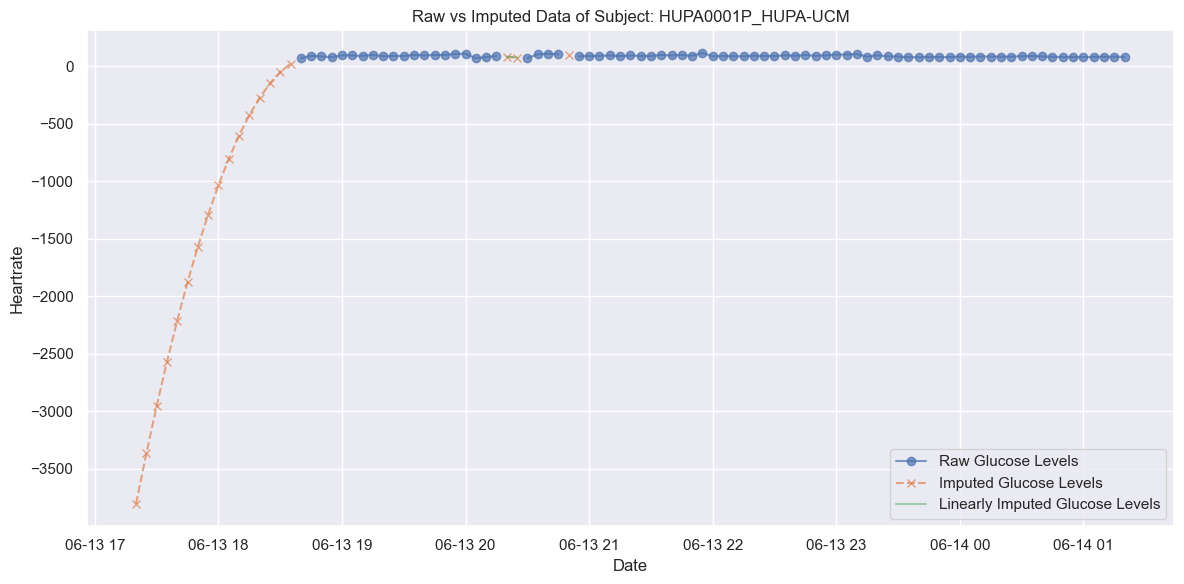

First 1-hour NaN gap starts at: 2018-06-14 21:40:00, ends at: 2018-06-14 22:55:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


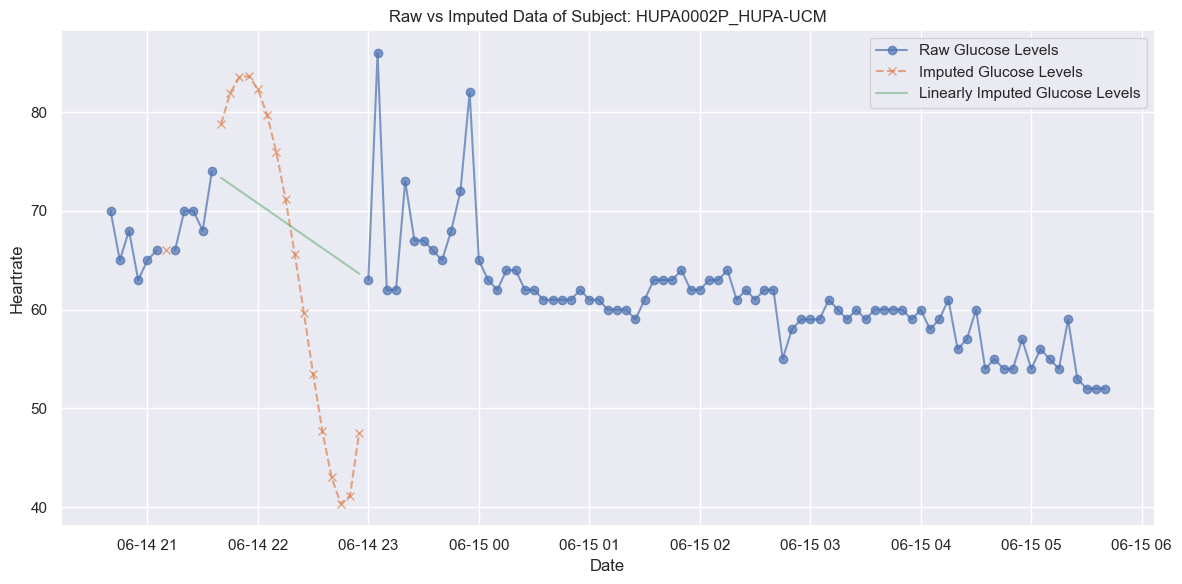

First 1-hour NaN gap starts at: 2018-06-21 18:20:00, ends at: 2018-06-21 18:55:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


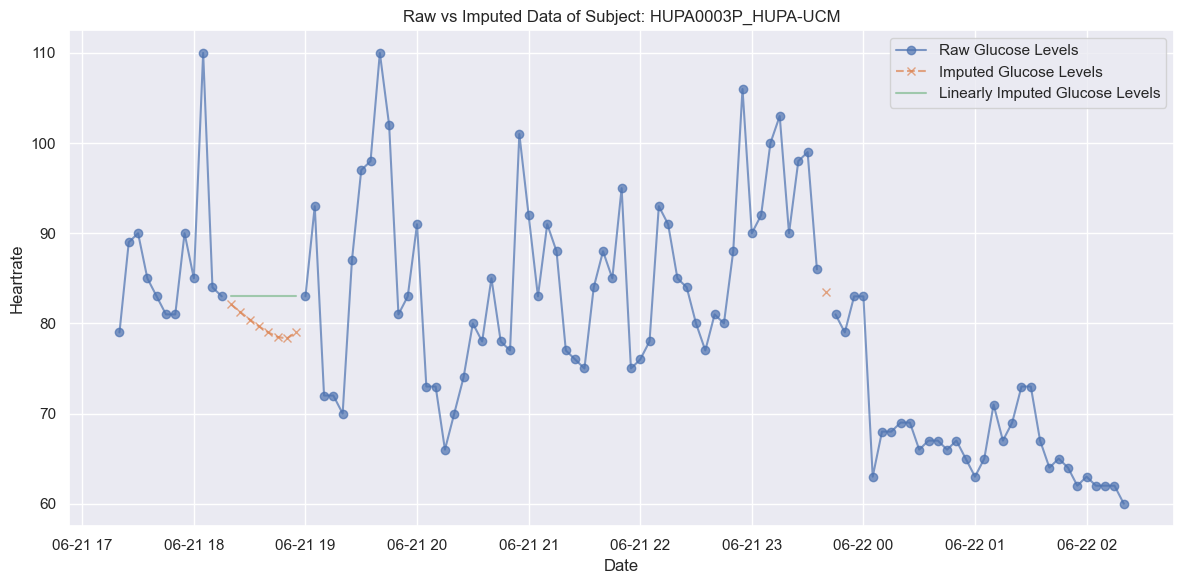

First 1-hour NaN gap starts at: 2018-07-12 01:05:00, ends at: 2018-07-12 01:40:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


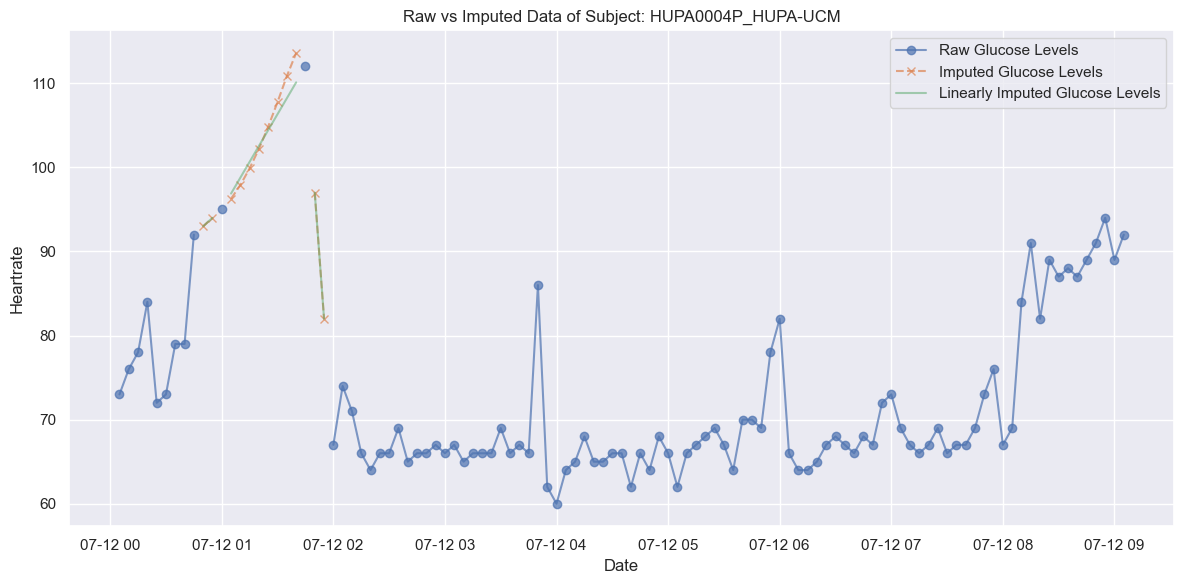

First 1-hour NaN gap starts at: 2018-07-10 12:20:00, ends at: 2018-07-10 13:00:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


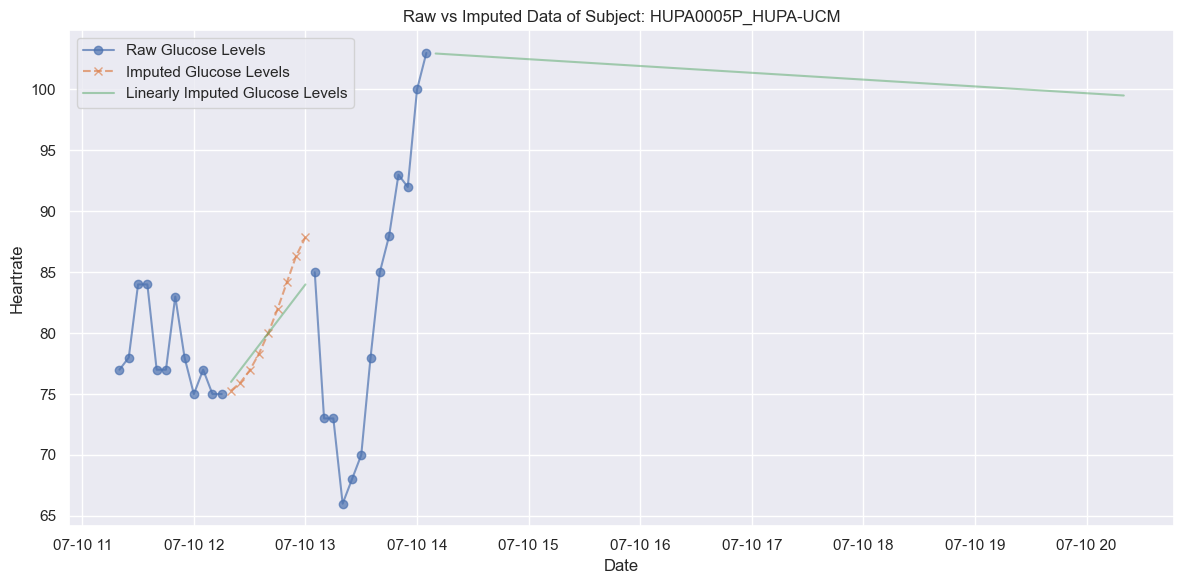

First 1-hour NaN gap starts at: 2018-07-14 18:45:00, ends at: 2018-07-14 19:25:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


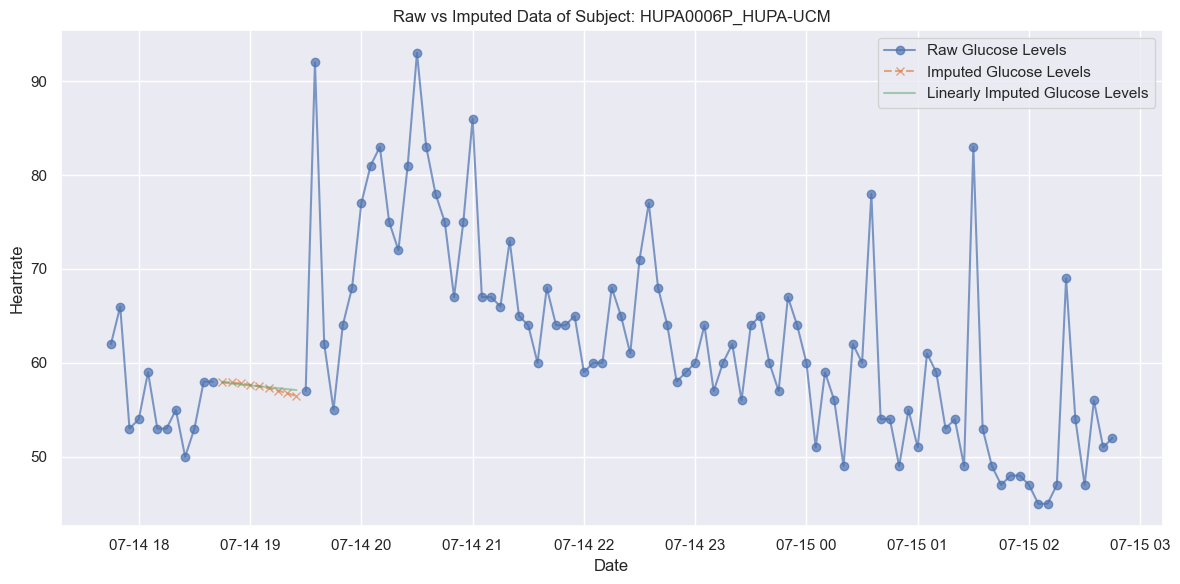

First 1-hour NaN gap starts at: 2018-09-19 22:10:00, ends at: 2018-09-19 22:35:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


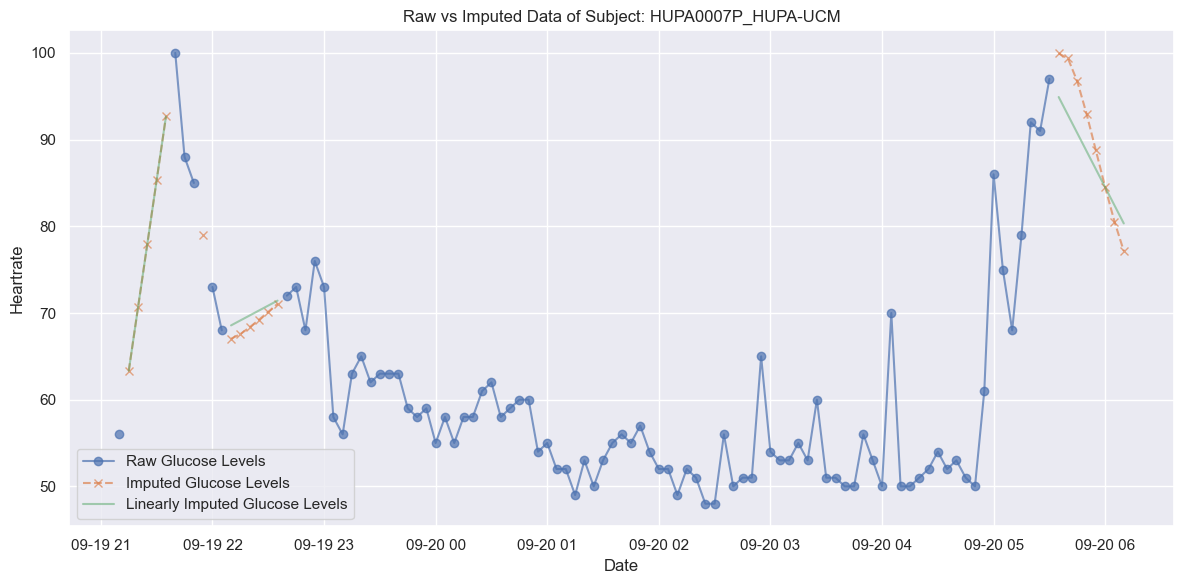

First 1-hour NaN gap starts at: 2018-11-08 07:35:00, ends at: 2018-11-08 08:00:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


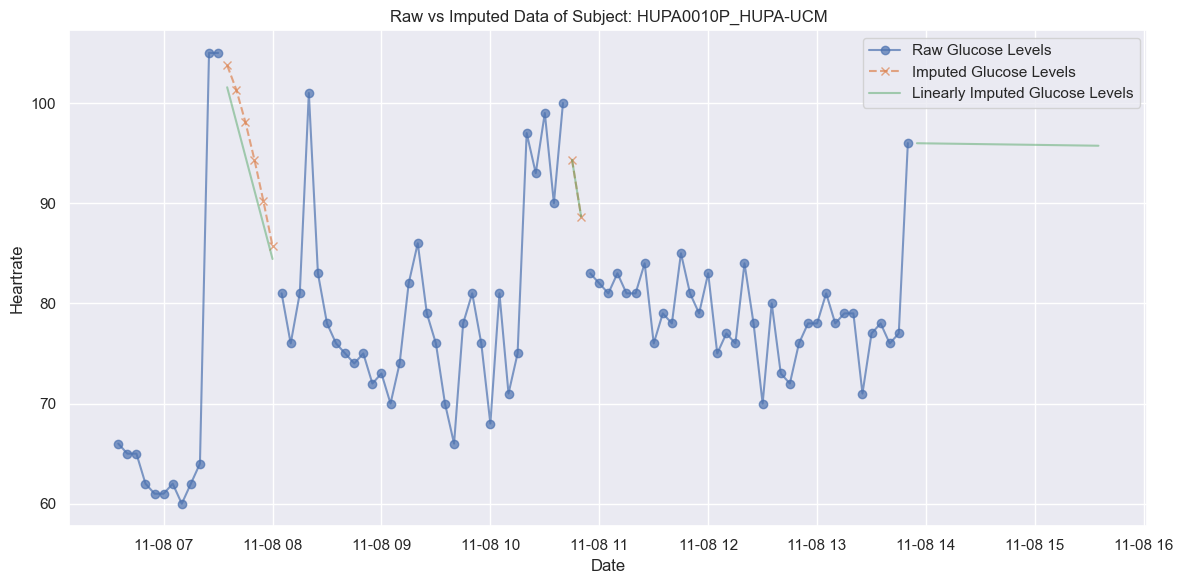

First 1-hour NaN gap starts at: 2018-11-08 09:35:00, ends at: 2018-11-08 10:20:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


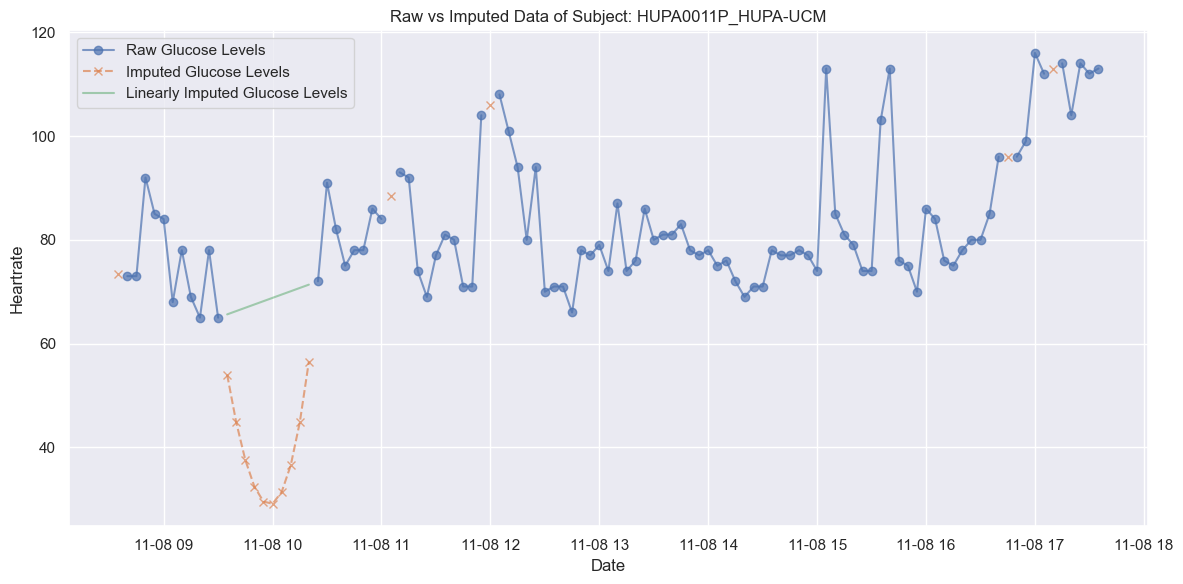

First 1-hour NaN gap starts at: 2018-11-09 16:55:00, ends at: 2018-11-09 18:20:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


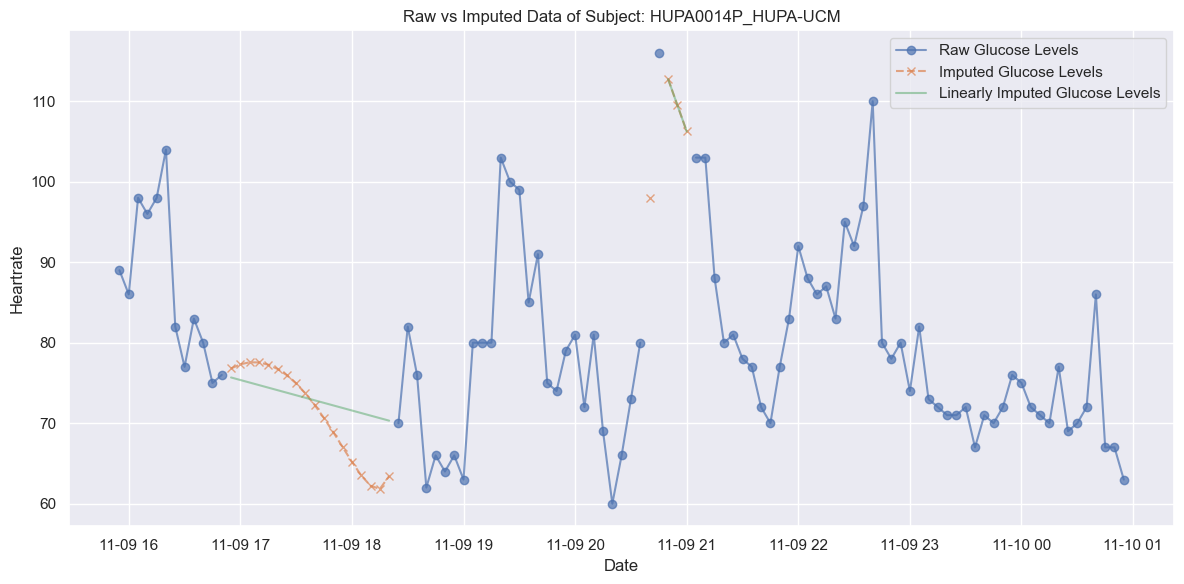

First 1-hour NaN gap starts at: 2019-03-27 19:25:00, ends at: 2019-03-27 20:00:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


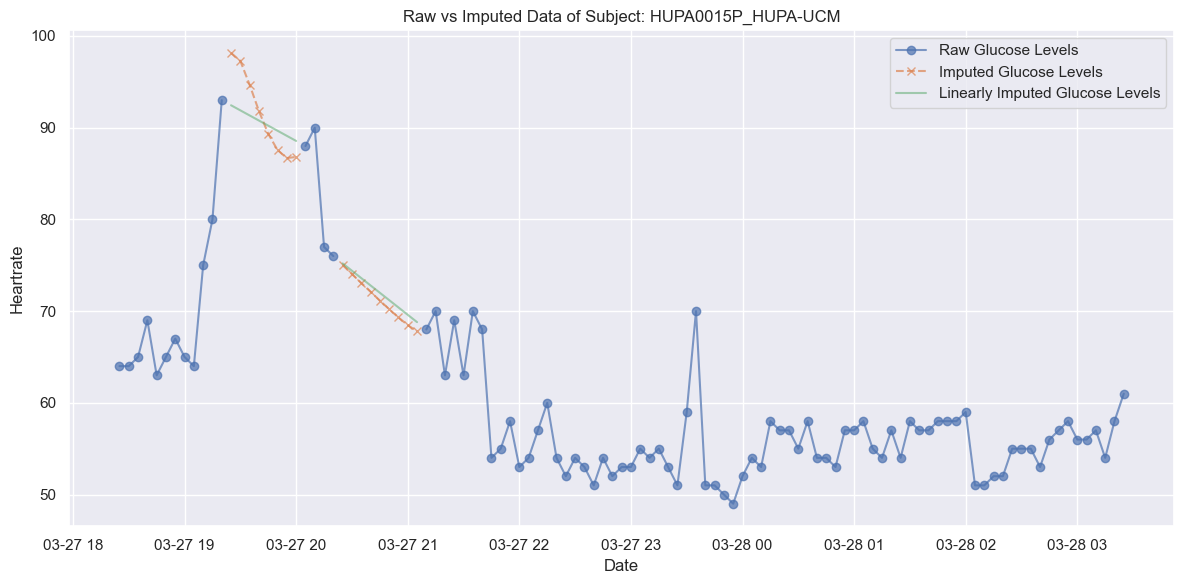

First 1-hour NaN gap starts at: 2019-03-27 19:55:00, ends at: 2019-03-27 21:00:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


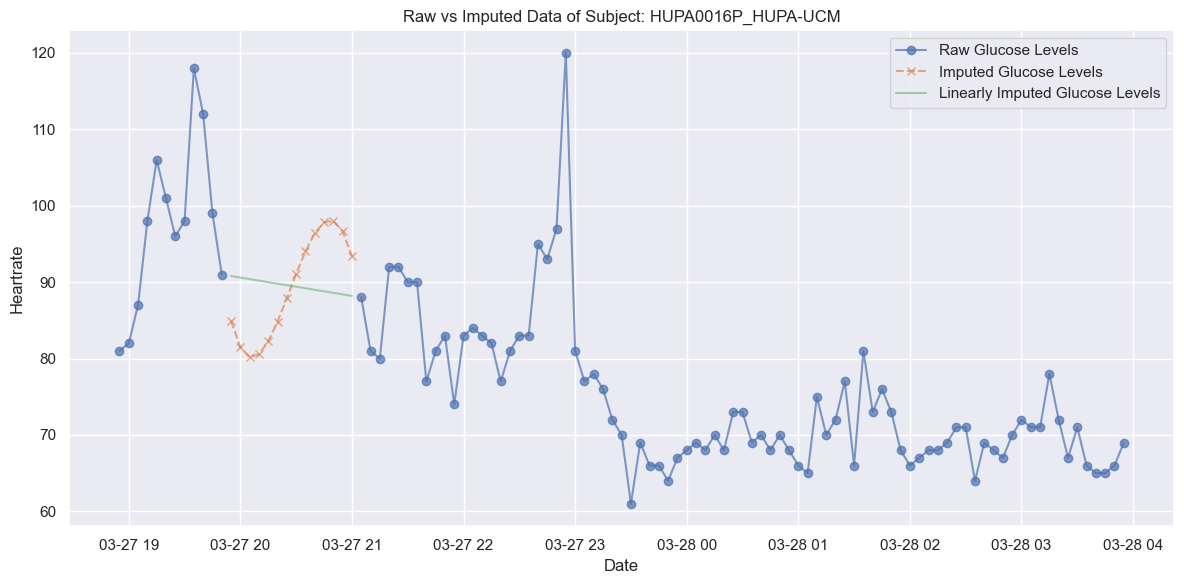

First 1-hour NaN gap starts at: 2019-03-28 20:40:00, ends at: 2019-03-28 21:35:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


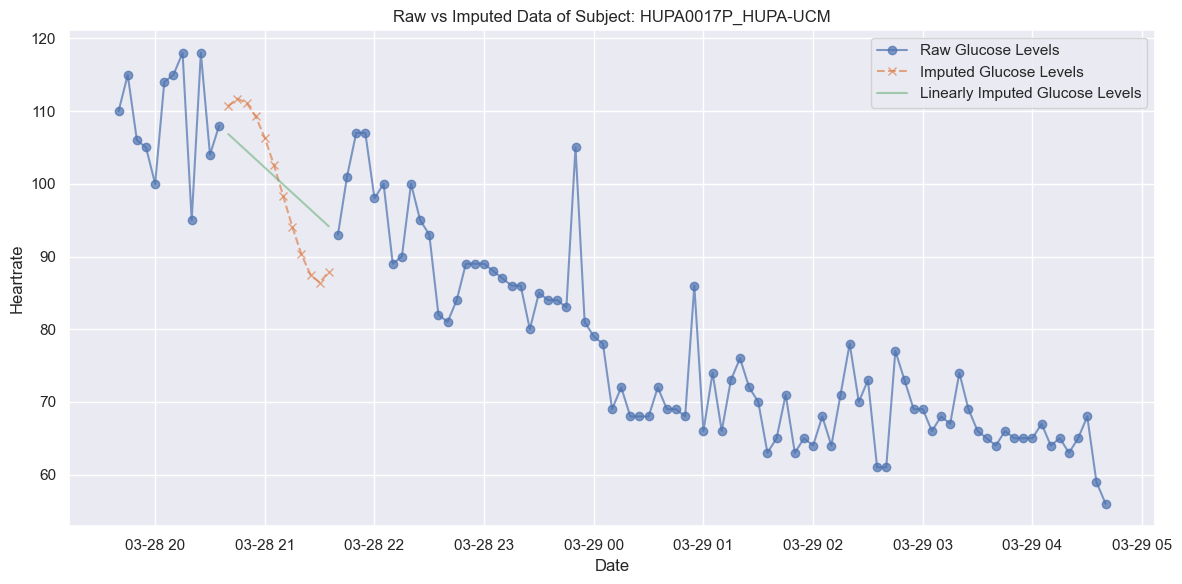

First 1-hour NaN gap starts at: 2019-07-07 10:35:00, ends at: 2019-07-07 11:55:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


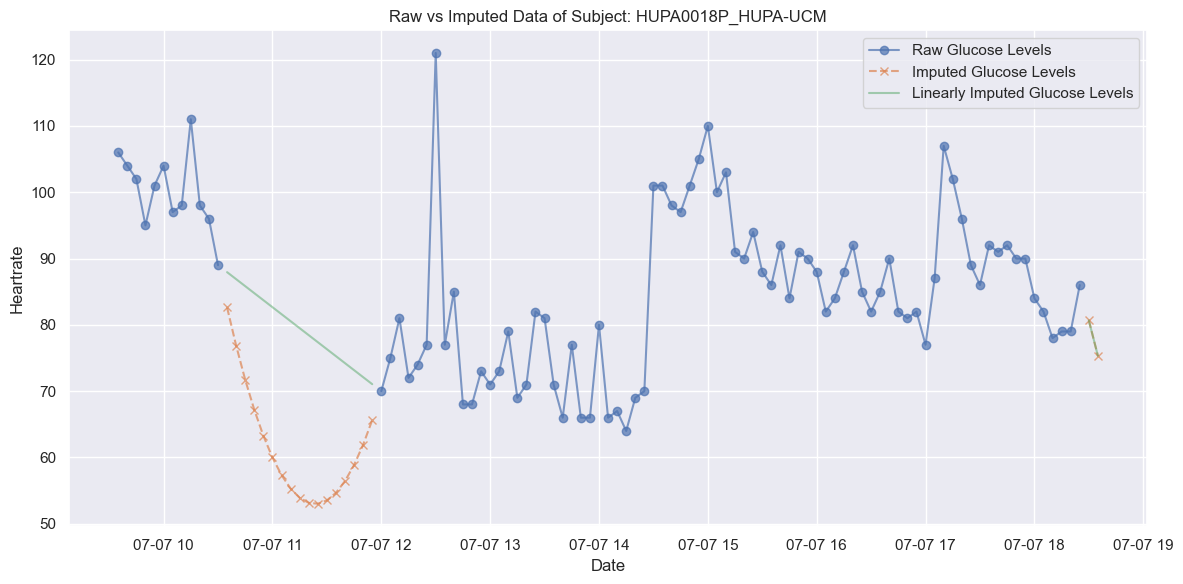

No 1-hour gap of continuous missing values found.
Non printable
First 1-hour NaN gap starts at: 2019-07-04 20:55:00, ends at: 2019-07-04 21:30:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


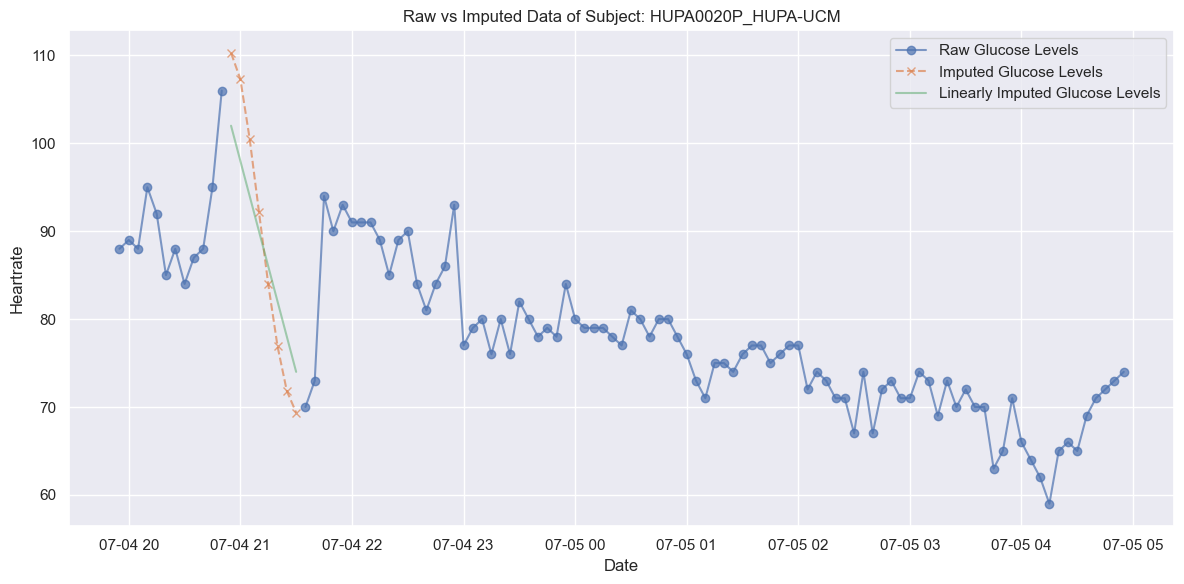

First 1-hour NaN gap starts at: 2019-07-03 10:45:00, ends at: 2019-07-03 12:20:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


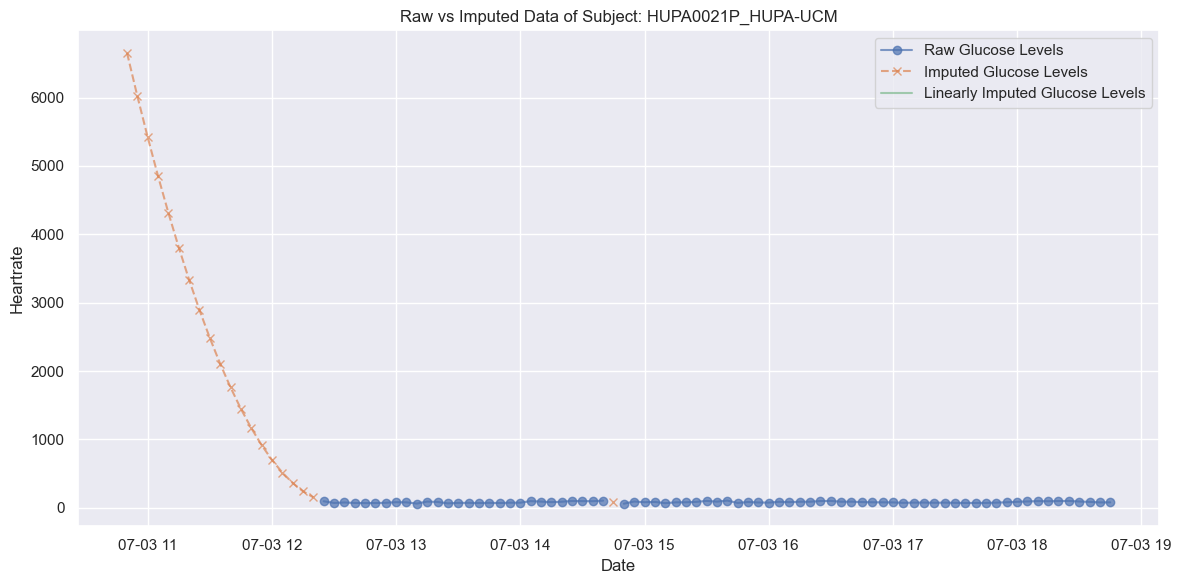

First 1-hour NaN gap starts at: 2020-01-19 15:05:00, ends at: 2020-01-19 16:40:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


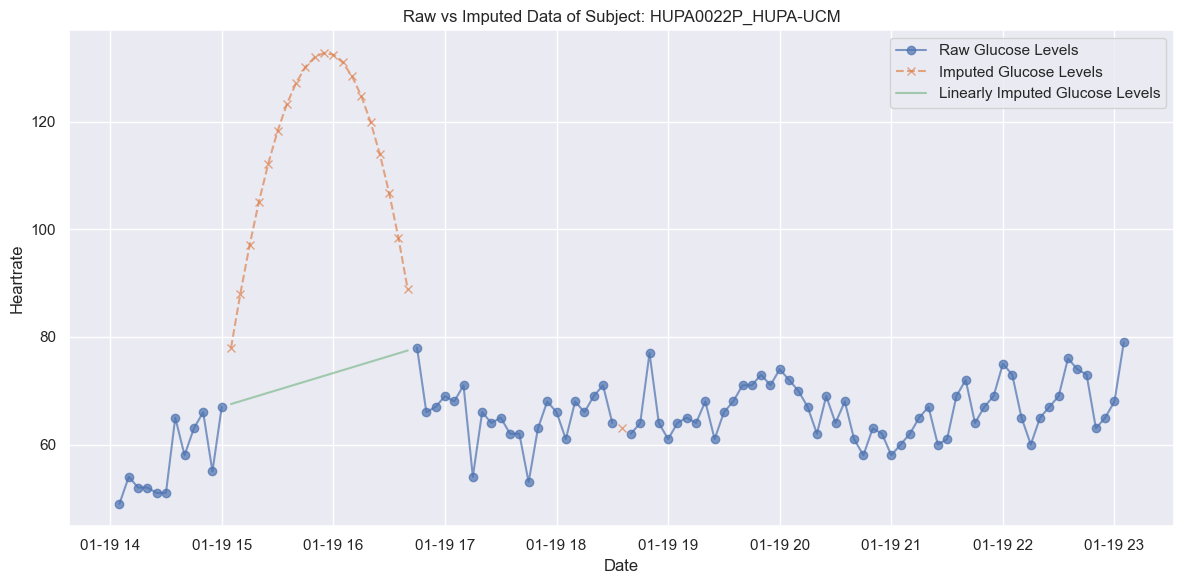

First 1-hour NaN gap starts at: 2020-01-18 13:35:00, ends at: 2020-01-18 14:35:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


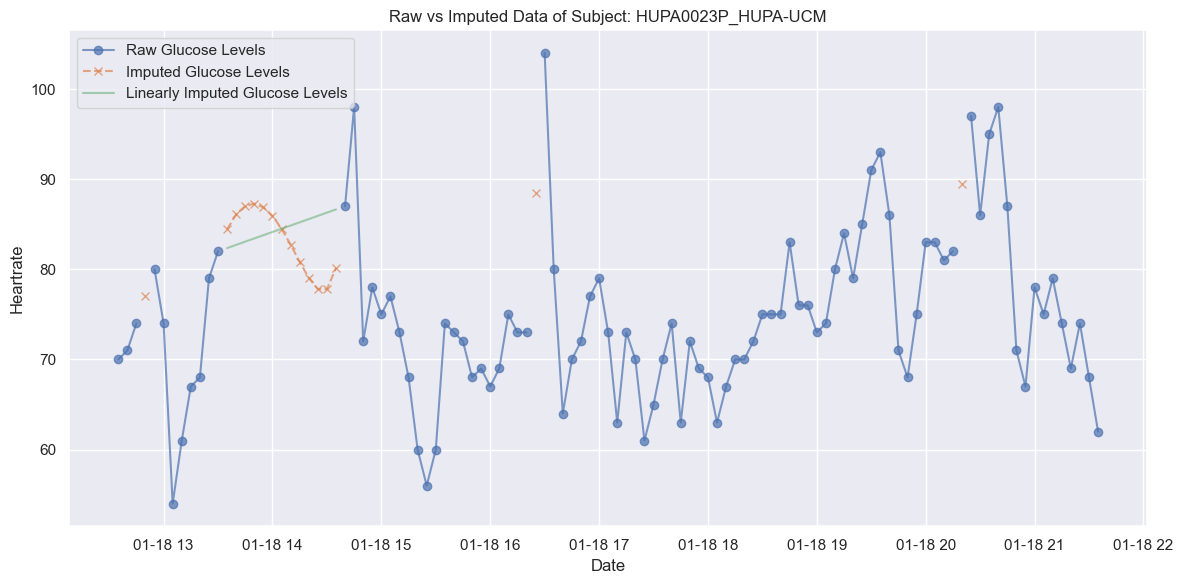

First 1-hour NaN gap starts at: 2020-01-26 09:15:00, ends at: 2020-01-26 10:00:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


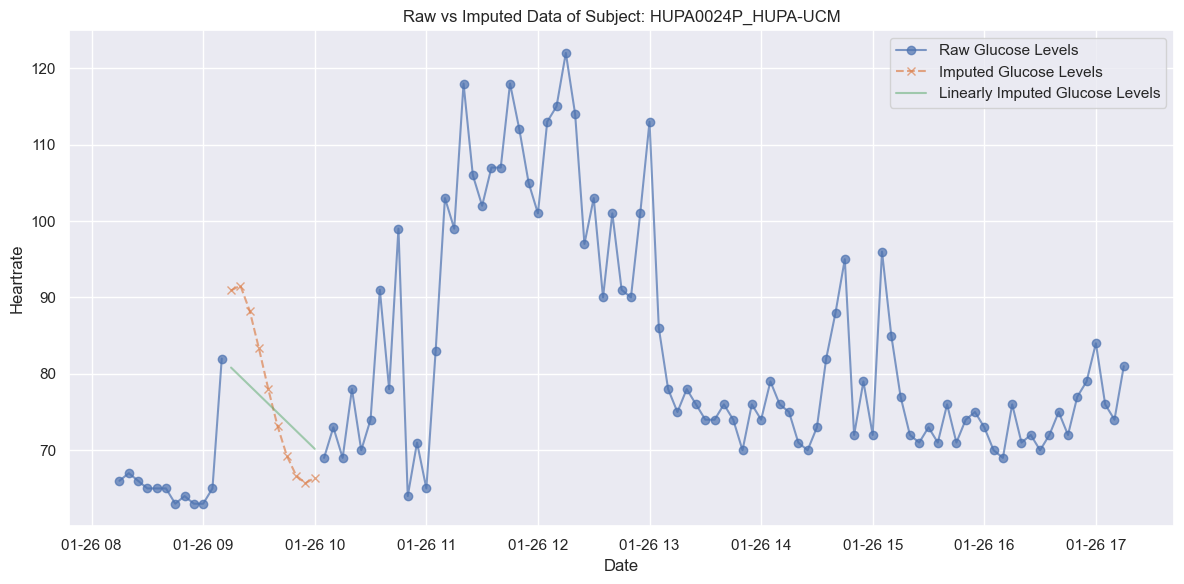

First 1-hour NaN gap starts at: 2020-01-16 12:45:00, ends at: 2020-01-16 13:10:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


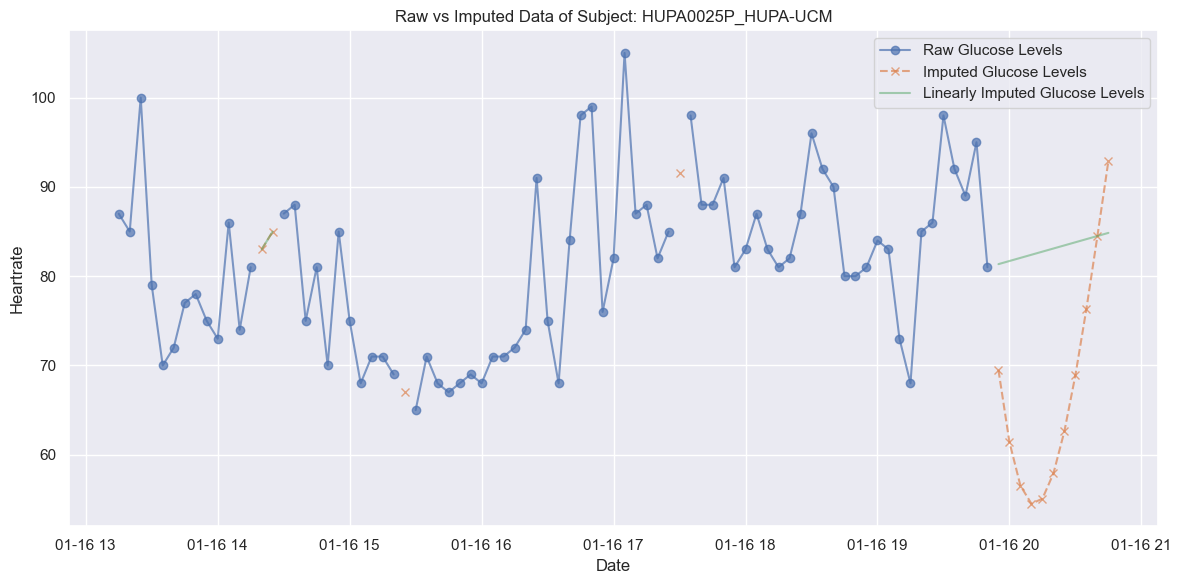

First 1-hour NaN gap starts at: 2020-05-16 19:40:00, ends at: 2020-05-16 20:15:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


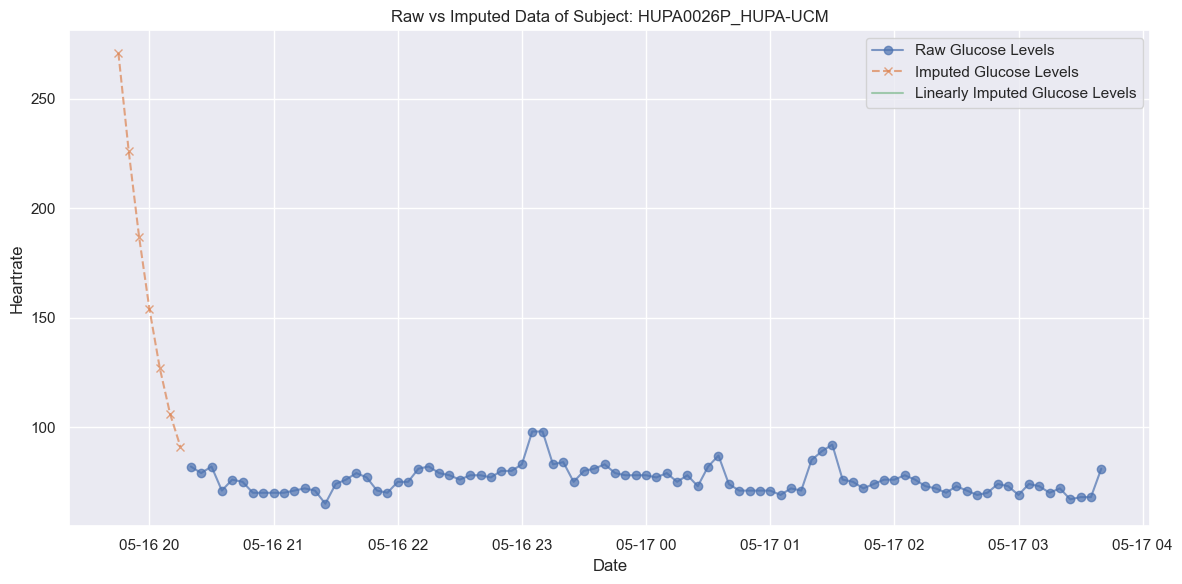

First 1-hour NaN gap starts at: 2020-06-30 08:10:00, ends at: 2020-06-30 09:00:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


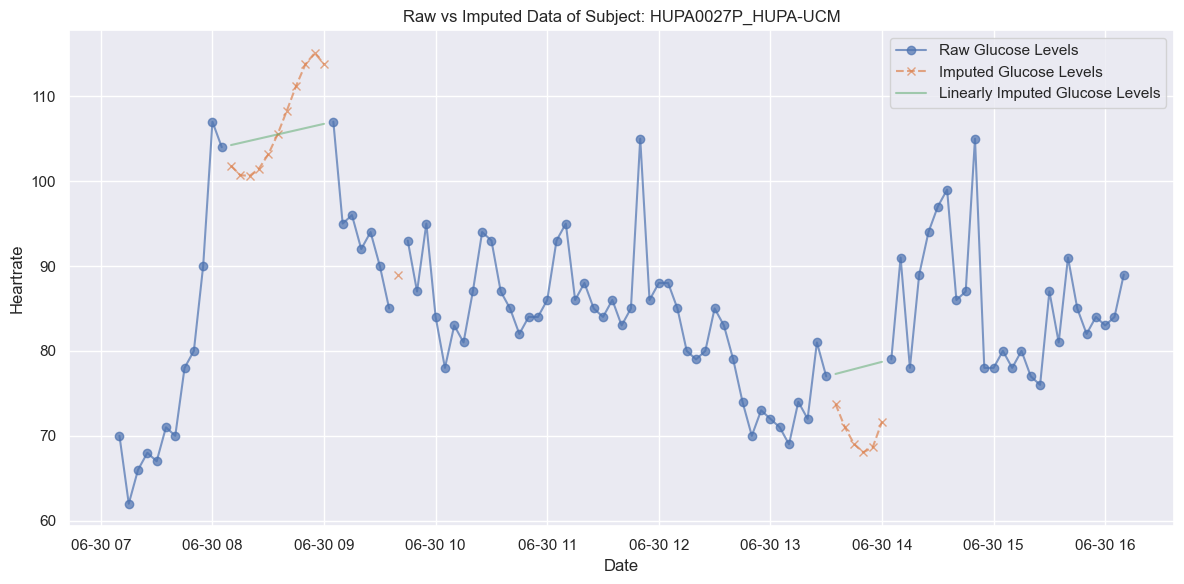

First 1-hour NaN gap starts at: 2022-02-17 14:55:00, ends at: 2022-02-17 15:25:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


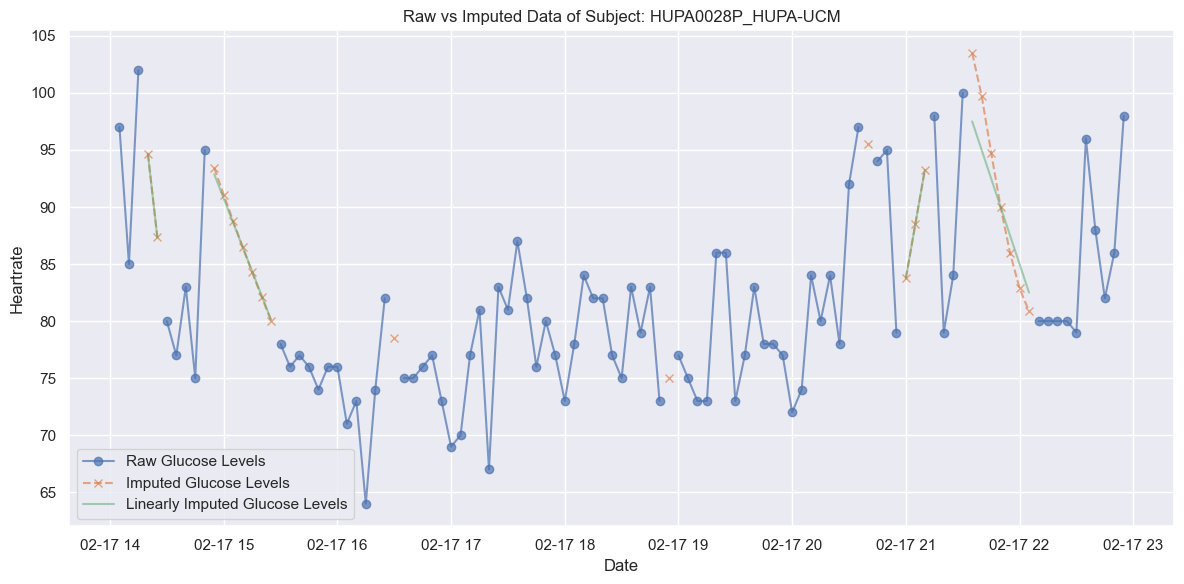

First 1-hour NaN gap starts at: 2014-10-02 13:30:00, ends at: 2014-10-02 14:05:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


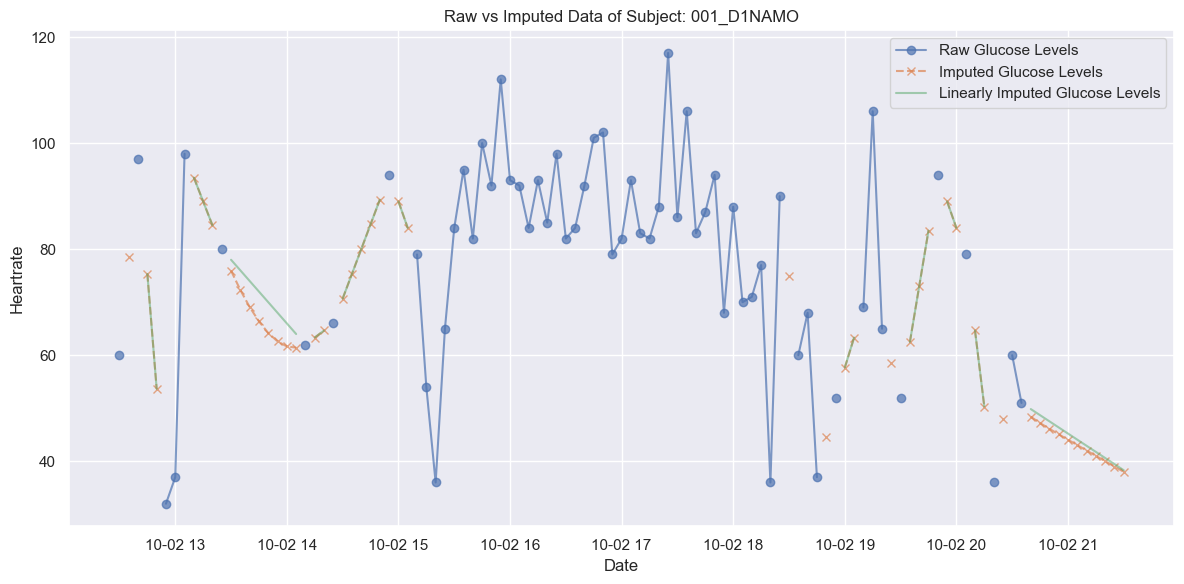

First 1-hour NaN gap starts at: 2014-10-01 12:30:00, ends at: 2014-10-01 12:55:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


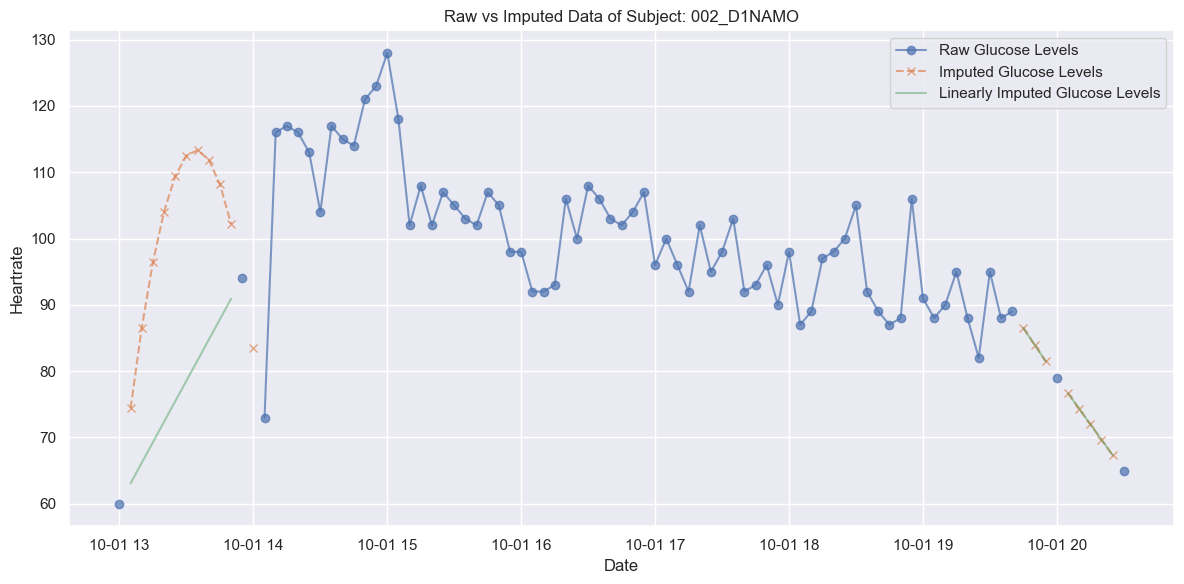

First 1-hour NaN gap starts at: 2014-10-01 10:15:00, ends at: 2014-10-01 10:45:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


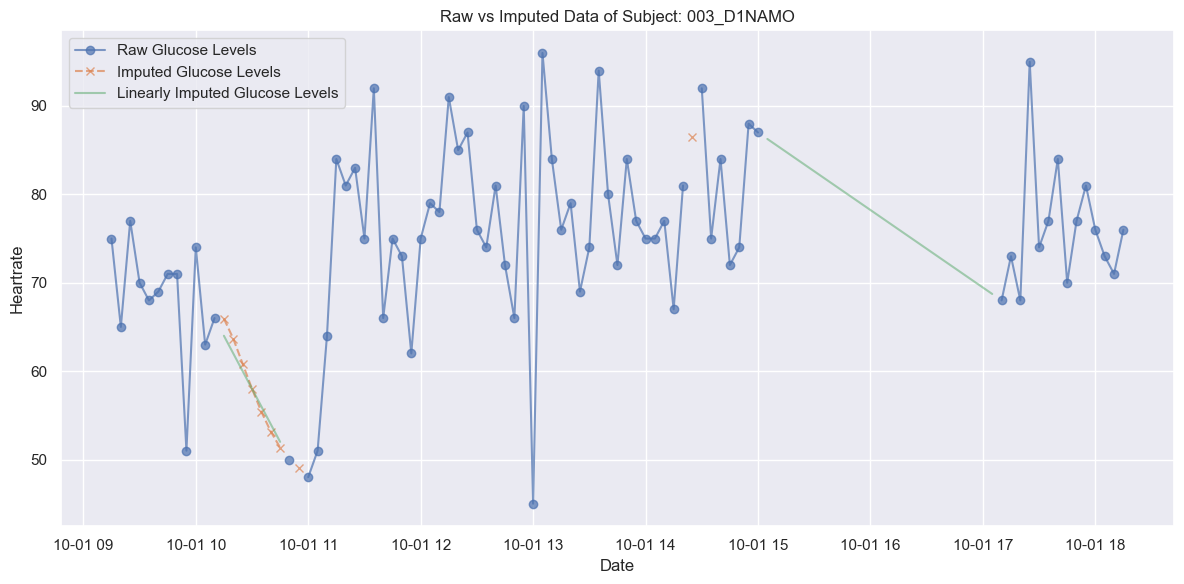

First 1-hour NaN gap starts at: 2014-10-01 14:45:00, ends at: 2014-10-01 15:10:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


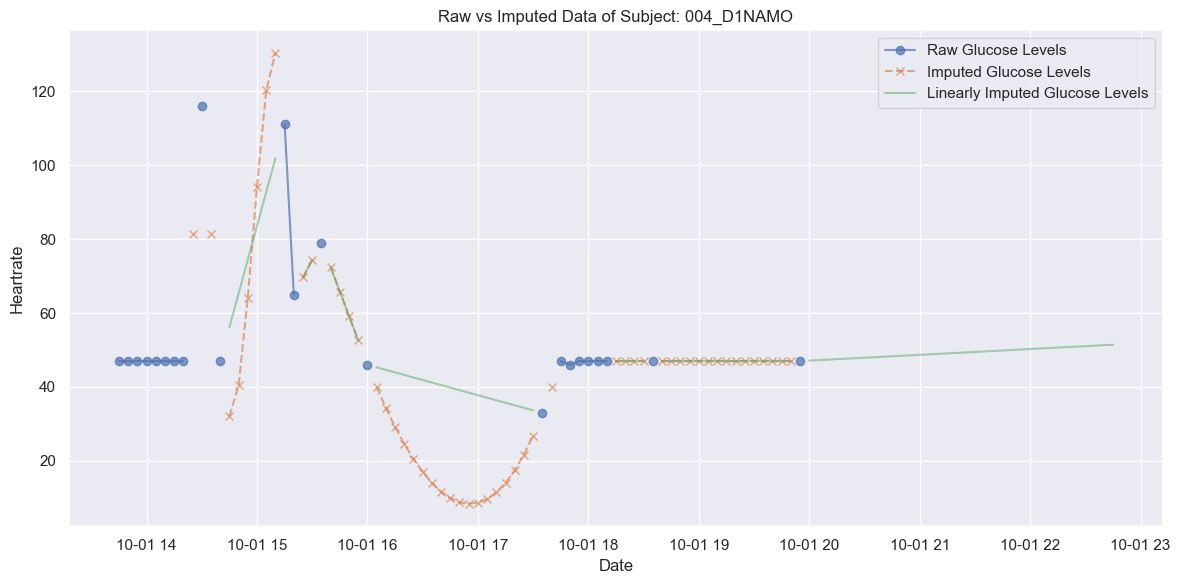

First 1-hour NaN gap starts at: 2014-10-01 12:40:00, ends at: 2014-10-01 13:45:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


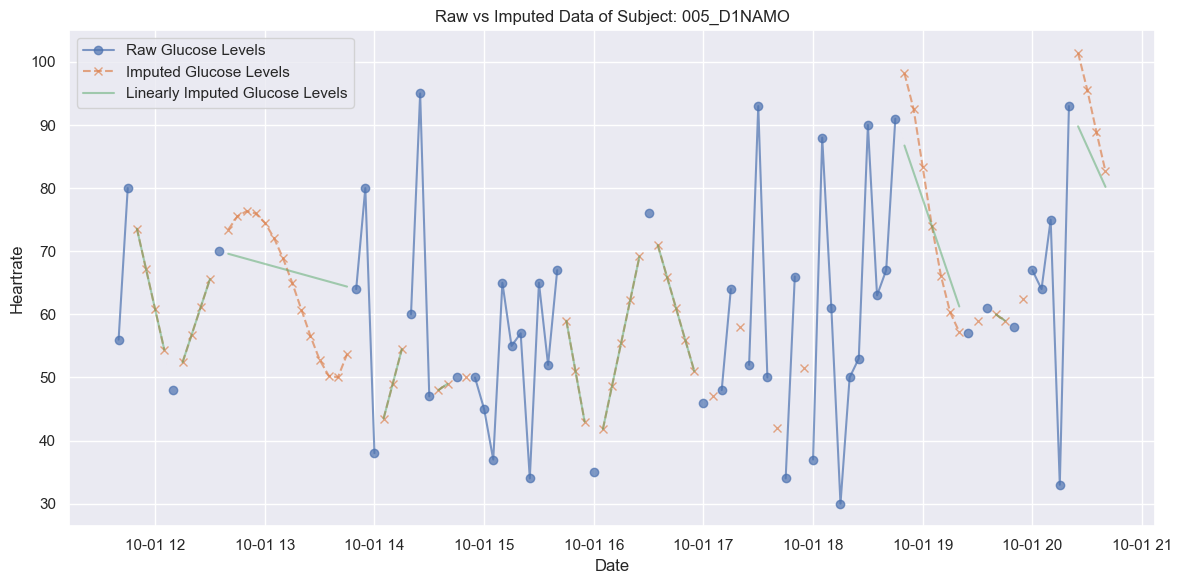

First 1-hour NaN gap starts at: 2014-10-02 00:15:00, ends at: 2014-10-02 00:50:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


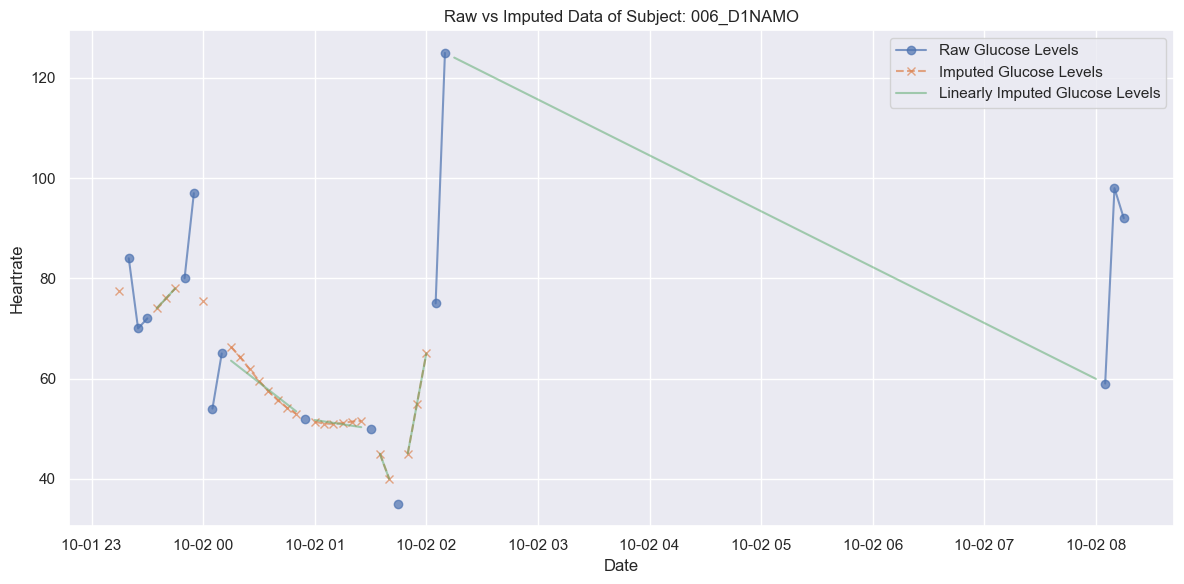

First 1-hour NaN gap starts at: 2014-10-02 09:15:00, ends at: 2014-10-02 10:20:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


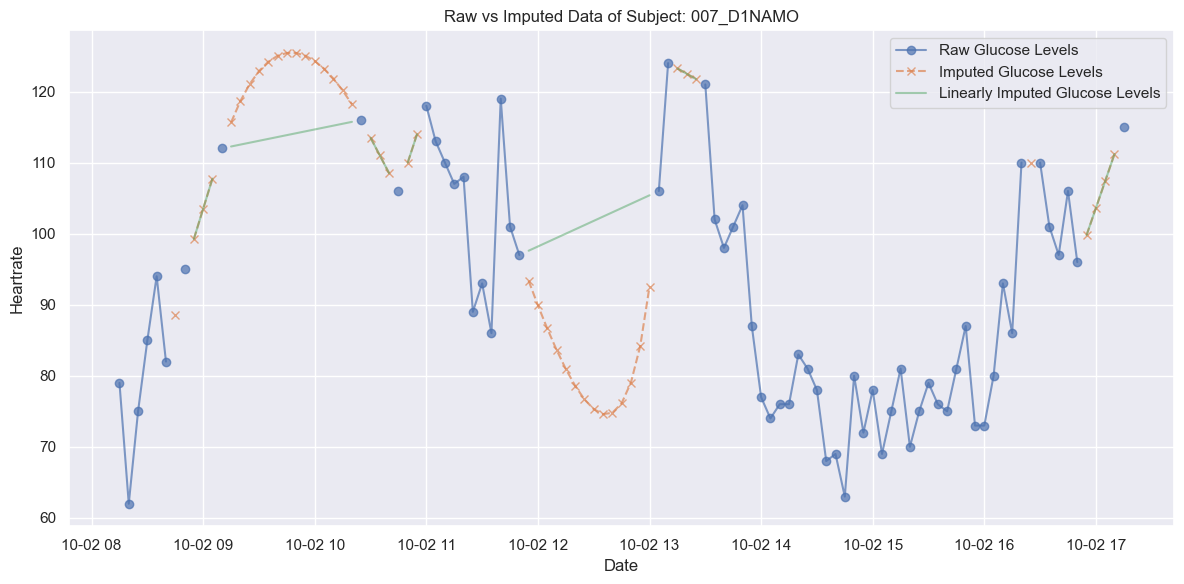

No 1-hour gap of continuous missing values found.
Non printable
First 1-hour NaN gap starts at: 2014-10-01 09:00:00, ends at: 2014-10-01 09:40:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


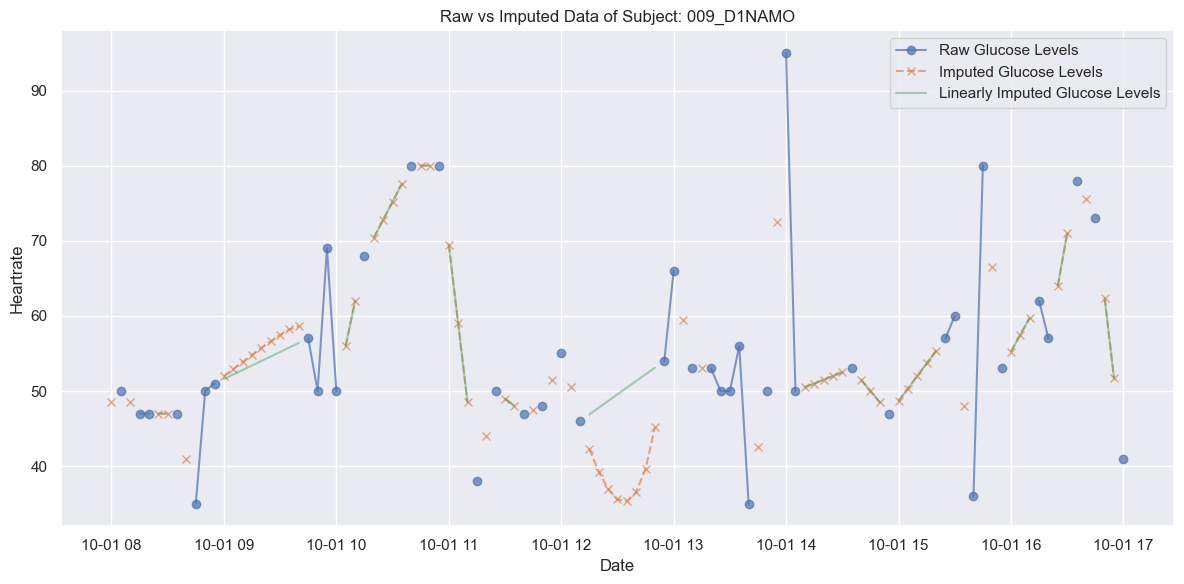

First 1-hour NaN gap starts at: 2019-10-23 10:40:00, ends at: 2019-10-23 11:50:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


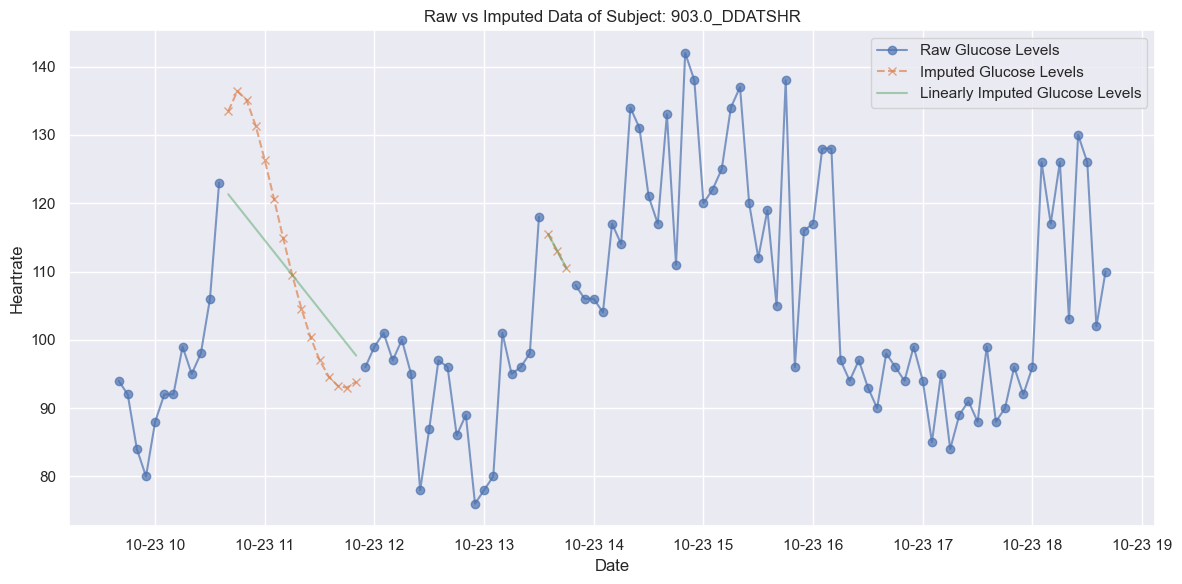

First 1-hour NaN gap starts at: 2019-10-15 07:40:00, ends at: 2019-10-15 08:05:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


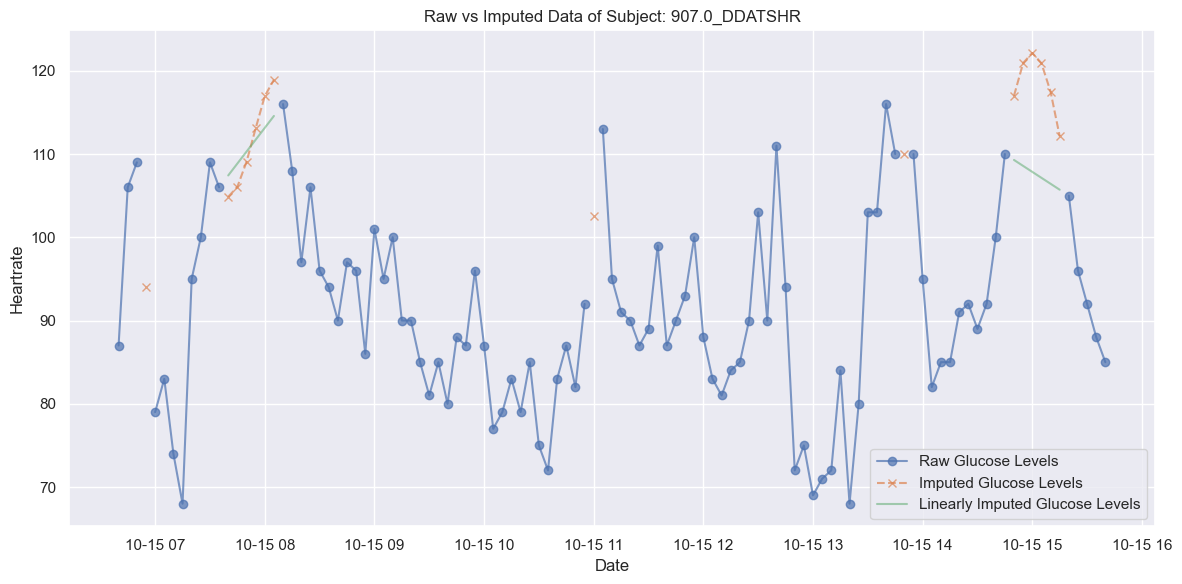

First 1-hour NaN gap starts at: 2019-10-26 04:55:00, ends at: 2019-10-26 05:25:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


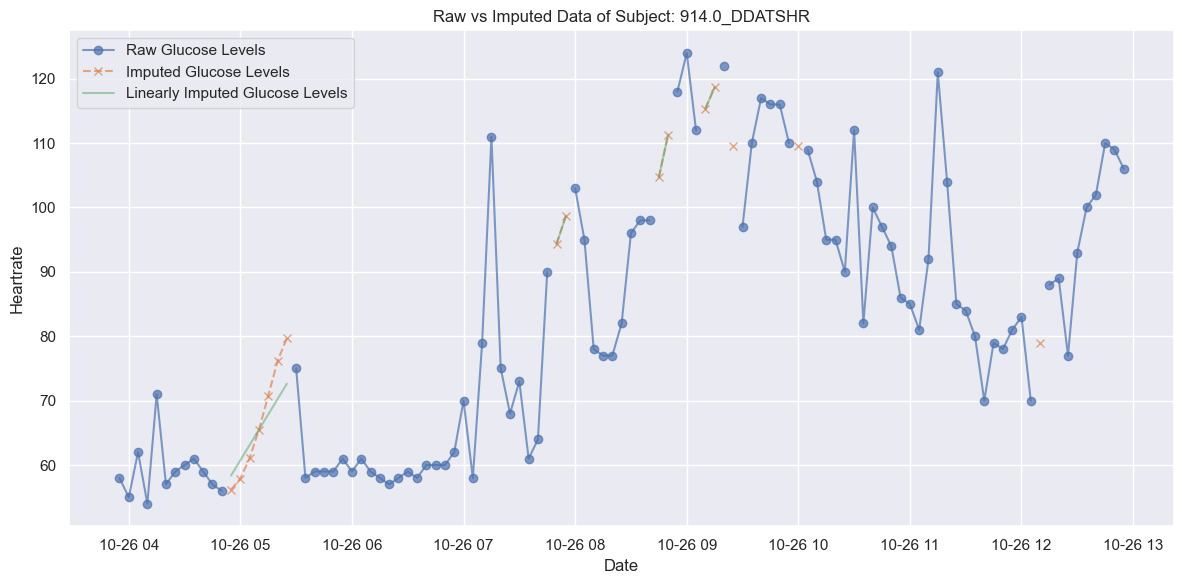

First 1-hour NaN gap starts at: 2019-10-15 19:45:00, ends at: 2019-10-15 20:35:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


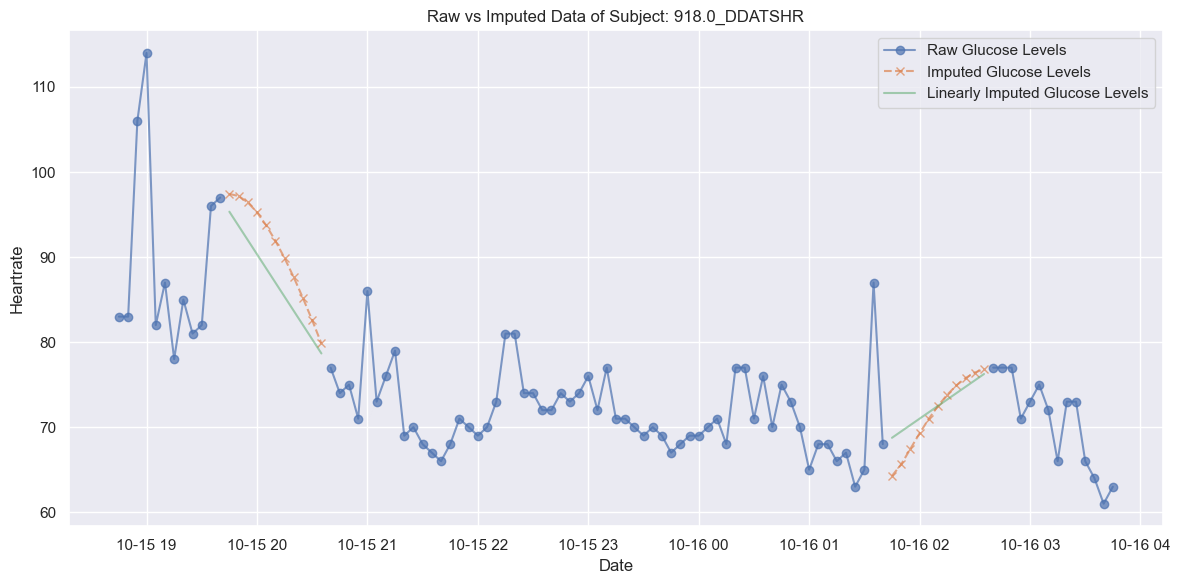

First 1-hour NaN gap starts at: 2019-10-15 10:35:00, ends at: 2019-10-15 11:20:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


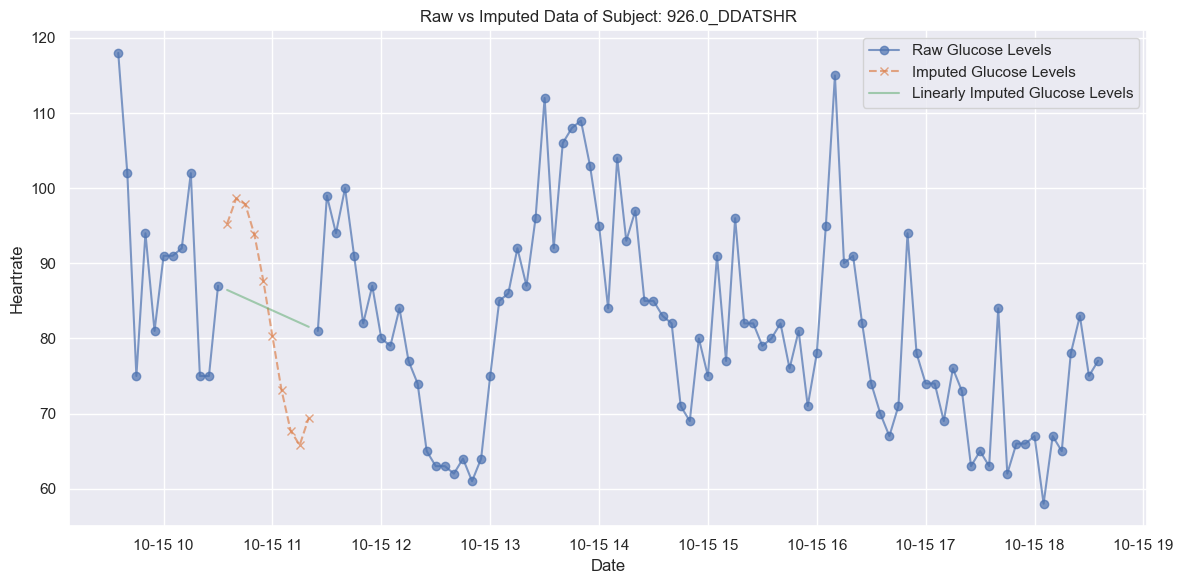

First 1-hour NaN gap starts at: 2019-10-16 04:35:00, ends at: 2019-10-16 06:05:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


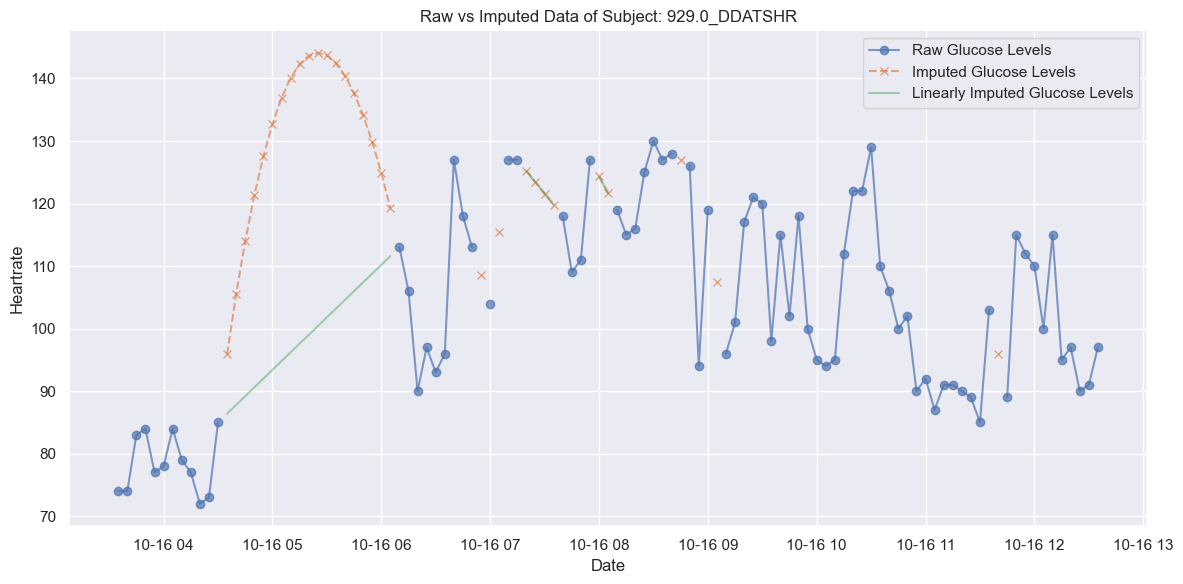

First 1-hour NaN gap starts at: 2019-10-15 19:35:00, ends at: 2019-10-15 20:35:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


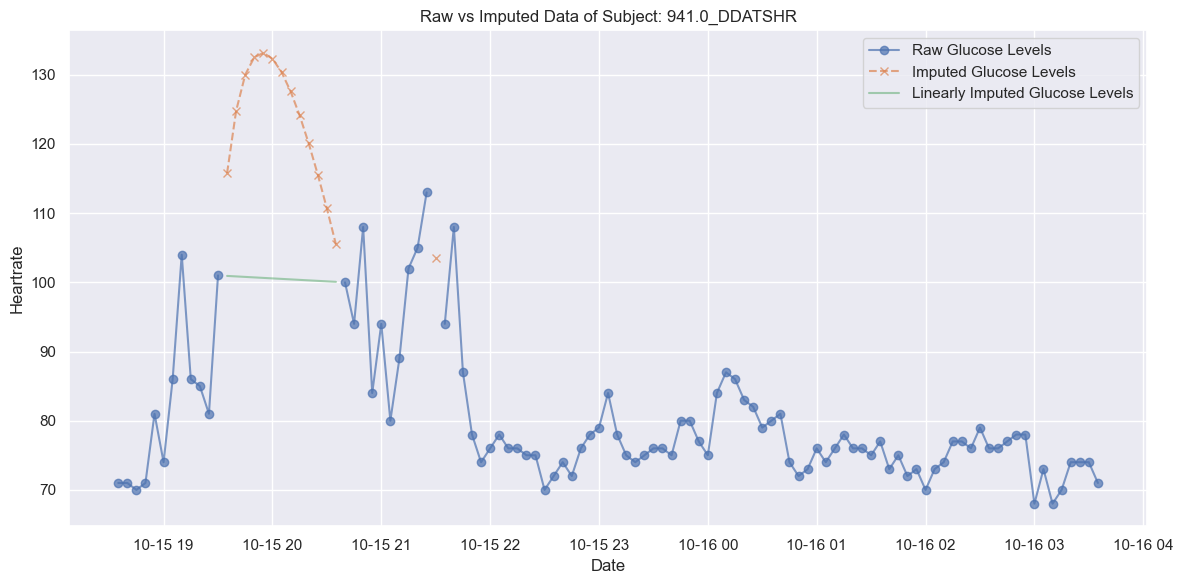

First 1-hour NaN gap starts at: 2019-10-19 01:10:00, ends at: 2019-10-19 01:55:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


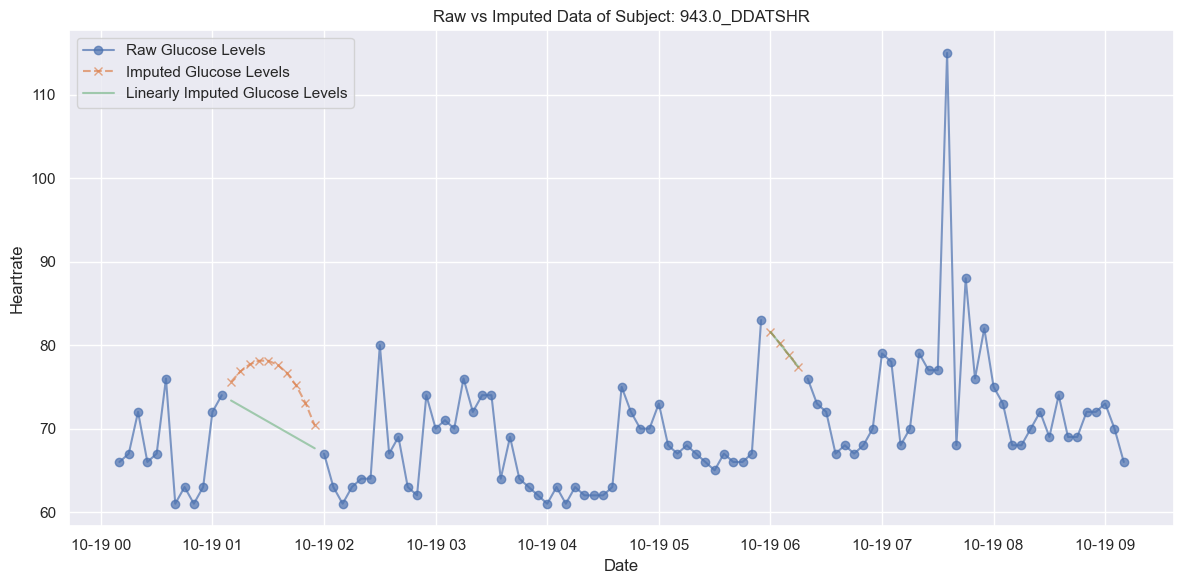

First 1-hour NaN gap starts at: 2019-10-15 16:45:00, ends at: 2019-10-15 17:15:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


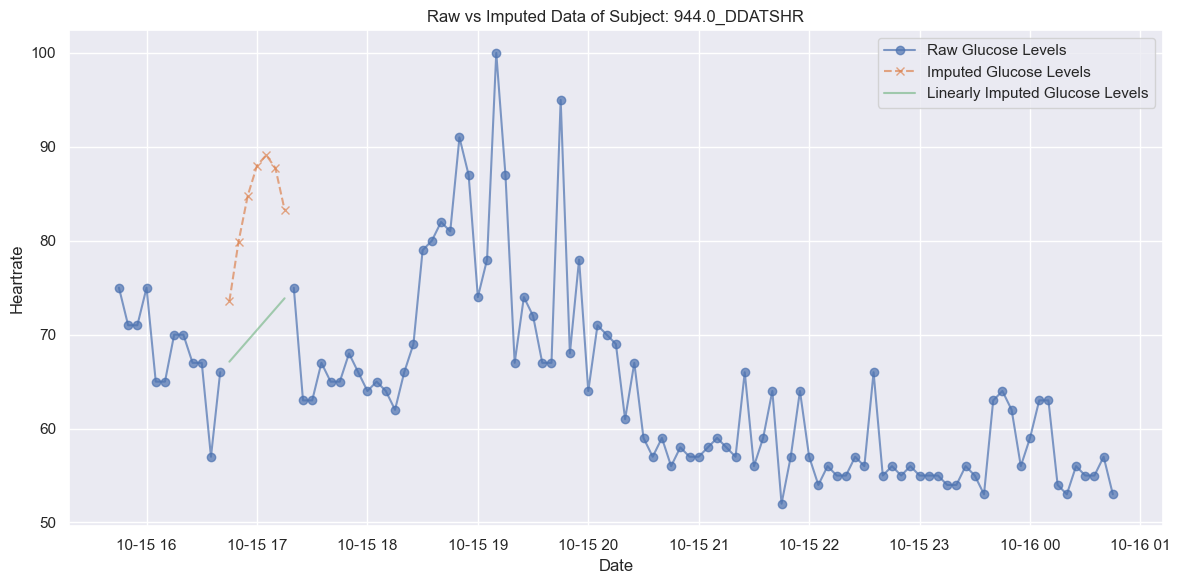

First 1-hour NaN gap starts at: 2019-10-15 19:00:00, ends at: 2019-10-15 19:45:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


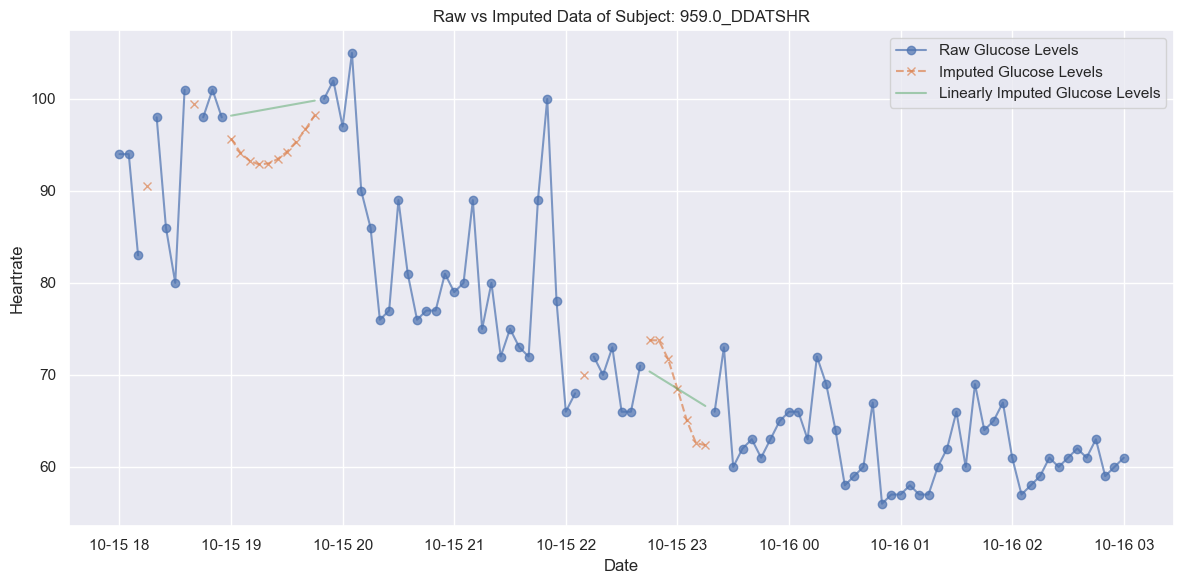

First 1-hour NaN gap starts at: 2019-10-16 13:55:00, ends at: 2019-10-16 14:20:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


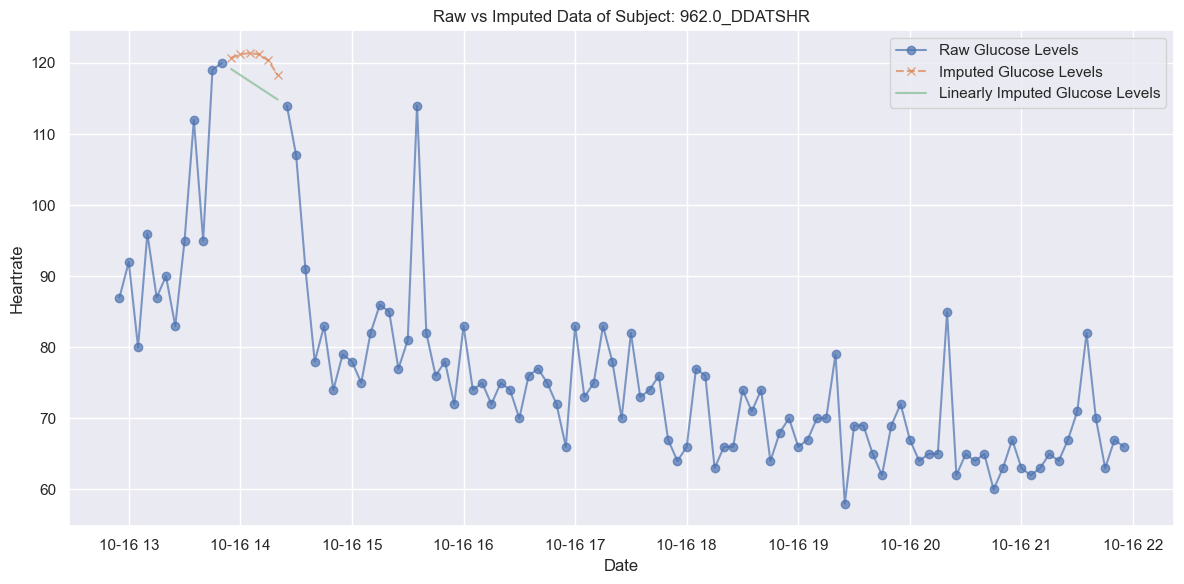

First 1-hour NaN gap starts at: 2019-10-15 18:20:00, ends at: 2019-10-15 19:00:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


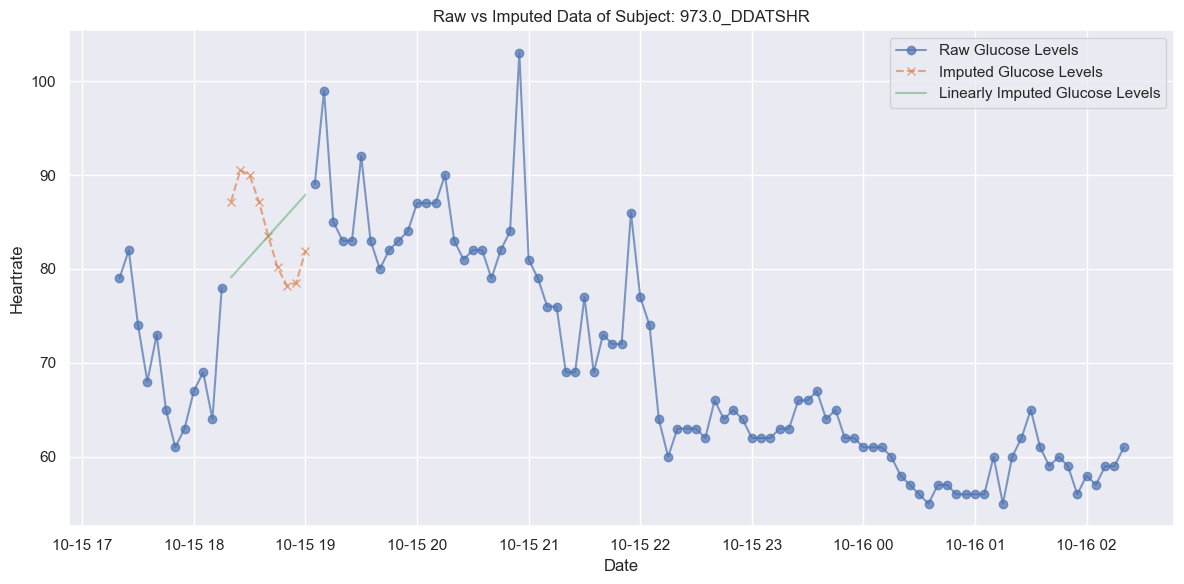

First 1-hour NaN gap starts at: 2019-10-24 09:55:00, ends at: 2019-10-24 11:40:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


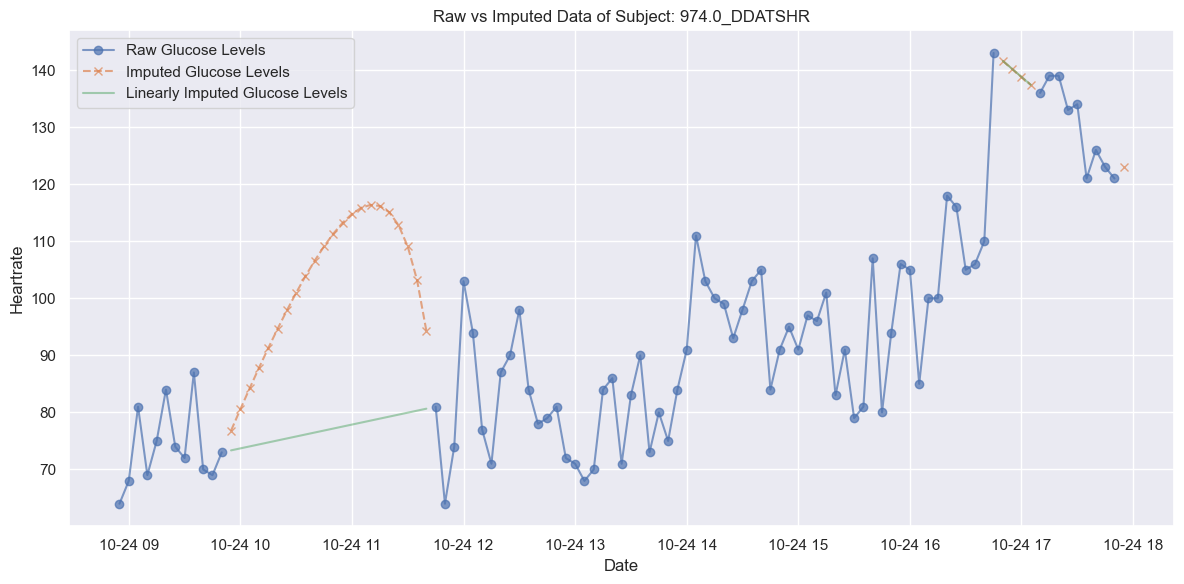

First 1-hour NaN gap starts at: 2019-10-22 05:30:00, ends at: 2019-10-22 06:10:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


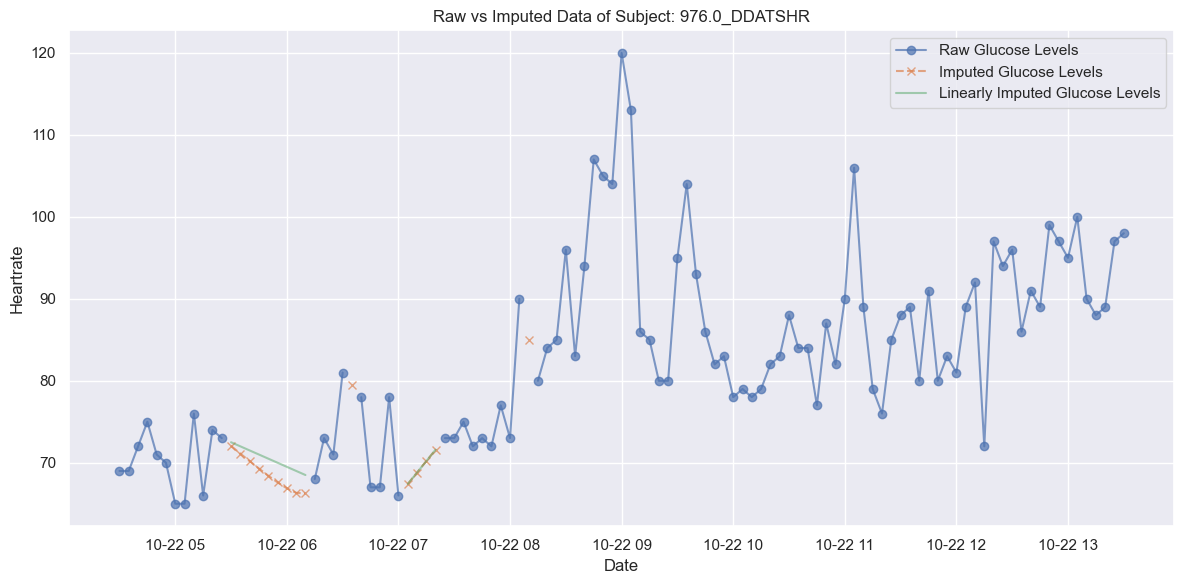

First 1-hour NaN gap starts at: 2019-10-16 18:40:00, ends at: 2019-10-16 20:15:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


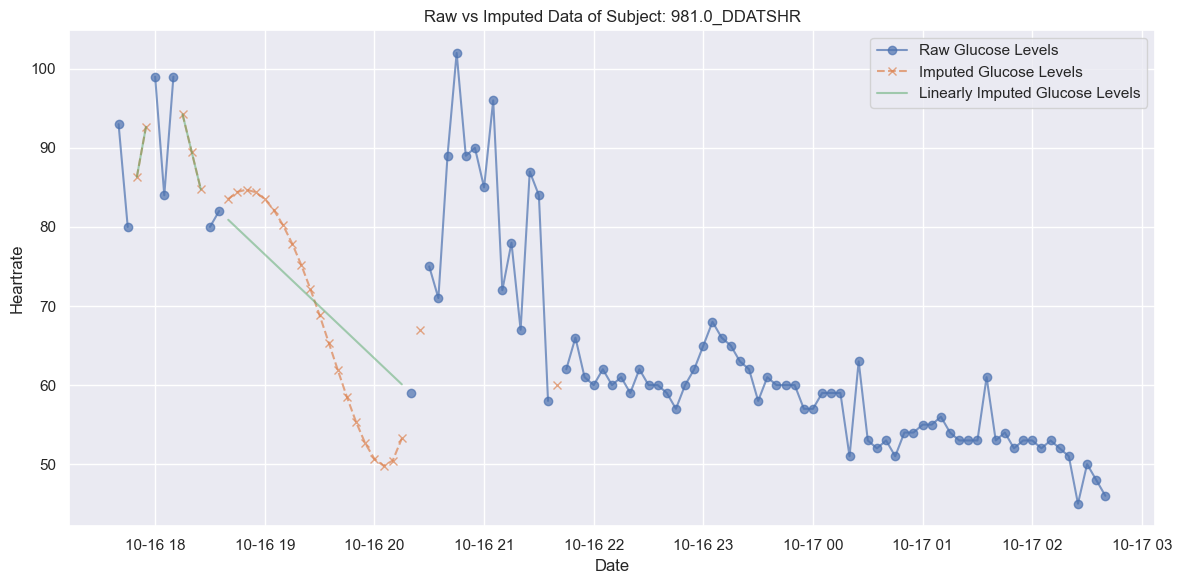

First 1-hour NaN gap starts at: 2019-10-20 12:25:00, ends at: 2019-10-20 12:55:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


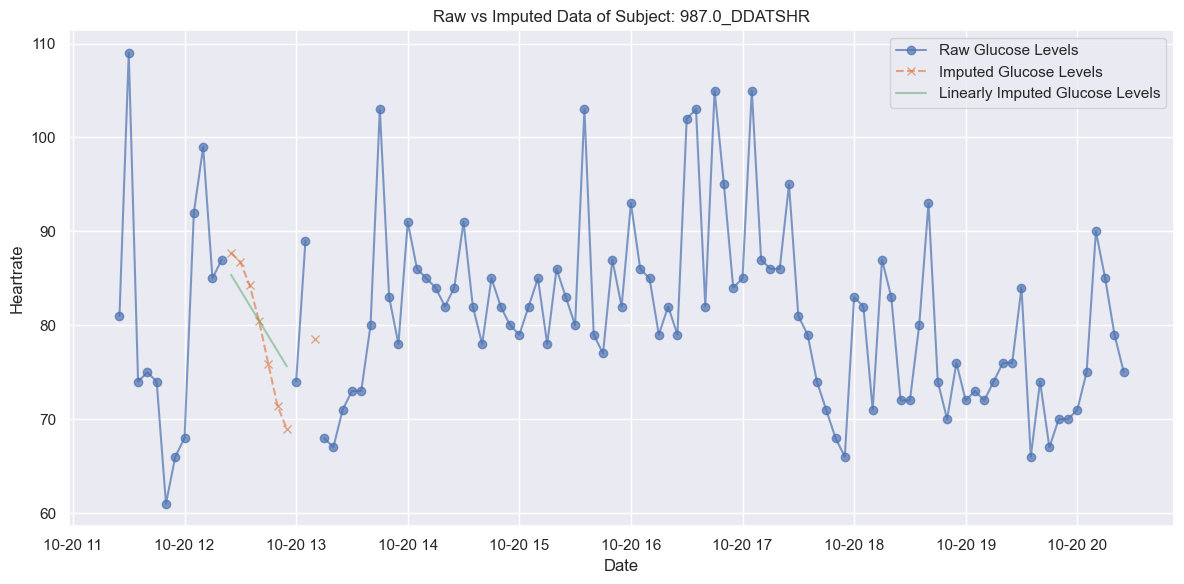

First 1-hour NaN gap starts at: 2019-11-04 06:45:00, ends at: 2019-11-04 07:10:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


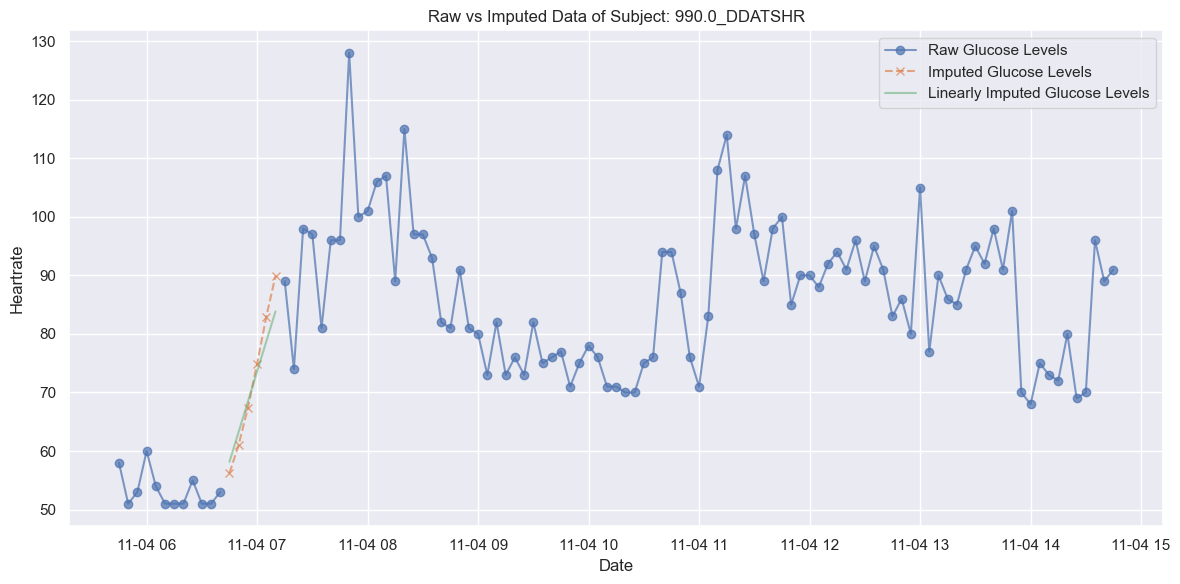

First 1-hour NaN gap starts at: 2019-10-19 19:50:00, ends at: 2019-10-19 20:30:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_35726/1002701696.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


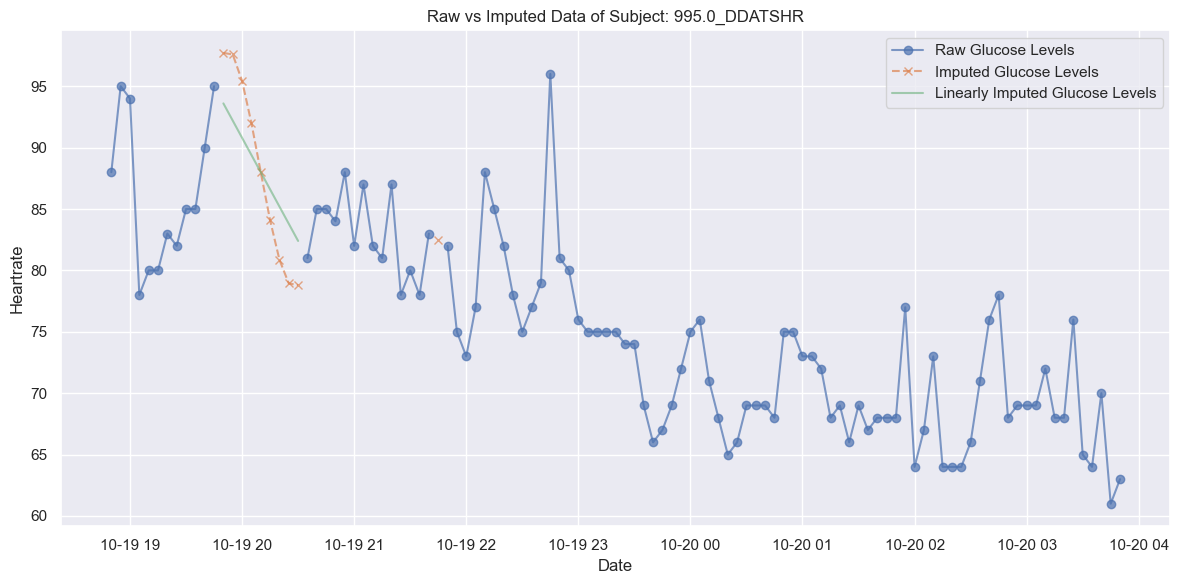

In [ ]:
subjects = subdatabaseII["PtID"].unique()
for i in subjects:
    plot_missing_values(data_cleaned, df_interpolated_stine, only_interpolated, i)

## Assign classes and generate time series

In [ ]:
# dataset with interpolated values is copied
classes_df = df_interpolated_stine.copy()
# initially all classes are assigned a class -1
classes_df["Class"] = -1
# hypoglycemic values are defined as class 0 with values equal and lower than 70 mg/dL
classes_df.loc[classes_df["GlucoseCGM"] <= 70, "Class"] = 0

# calls the function class_generation to assing classes based on wanted intervals before hypogylcemia for each subject separately
classes_df = classes_df.groupby("PtID", group_keys=False).apply(lambda x: data_preprocessing.class_generation(x,"ts", 5, 15, 1)) # 5-15 min
classes_df = classes_df.groupby("PtID", group_keys=False).apply(lambda x: data_preprocessing.class_generation(x,"ts", 15, 30, 2)) # 15-30 min
classes_df = classes_df.groupby("PtID", group_keys=False).apply(lambda x: data_preprocessing.class_generation(x,"ts", 30, 60, 3))  # 30-60 min
classes_df = classes_df.groupby("PtID", group_keys=False).apply(lambda x: data_preprocessing.class_generation(x,"ts",  60, 125, 4)) # 1-2 h
classes_df.loc[classes_df["Class"] == -1, "Class"] = 5

# sorts the glucose values by patient id and timestamps
df_sorted = classes_df.sort_values(by=['PtID', 'ts'])
# reindexes based on the sorted dataset
df_sorted = df_sorted.reset_index(drop=True)

In [ ]:
# prints the number of each value accross classes
df_sorted["Class"].value_counts()

Class
5    1480967
0      39842
4      39028
3      20174
2      10726
1       7416
Name: count, dtype: int64

## Normalization

In [ ]:
# normalizes data 
df_min_max_scaled = data_preprocessing.normalize_data(df_sorted, 'GlucoseCGM')
df_min_max_scaled = data_preprocessing.normalize_data(df_min_max_scaled, 'HR')	 

## Correlation Analysis

In [ ]:
# applies correlation analysis between glucose and heart rate values for the whole dataset
print(df_min_max_scaled['GlucoseCGM'].corr(df_min_max_scaled['HR']))
print(df_min_max_scaled['GlucoseCGM'].corr(df_min_max_scaled['HR'], method = "spearman"))
print(df_min_max_scaled['GlucoseCGM'].corr(df_min_max_scaled['HR'], method = "kendall"))
# applies correlation analysis between glucose and heart rate values for the assigned classes
cor_by_category = df_min_max_scaled.groupby('Class').apply(lambda g: g['GlucoseCGM'].corr(g['HR']))
print(cor_by_category)
cor_by_category = df_min_max_scaled.groupby('Class').apply(lambda g: g['GlucoseCGM'].corr(g['HR'], method = "spearman"))
print(cor_by_category)
cor_by_category = df_min_max_scaled.groupby('Class').apply(lambda g: g['GlucoseCGM'].corr(g['HR'], method = "kendall"))
print(cor_by_category)

0.03895792156362328
0.06505394094515342
0.04377171604045452
Class
0    0.124604
1    0.148030
2    0.134193
3    0.044064
4    0.025597
5    0.082878
dtype: float64
Class
0    0.117446
1    0.195577
2    0.300215
3    0.266700
4    0.204602
5    0.084097
dtype: float64
Class
0    0.078641
1    0.134342
2    0.206714
3    0.183289
4    0.139777
5    0.056598
dtype: float64


In [ ]:
# After correlation analysis, missing values in the heart rate column are replaced with zero
df_min_max_scaled["HR"] = df_min_max_scaled['HR'].fillna(0)

## Genearte time series 

In [ ]:
# generates time series with sliding window approach
result = df_min_max_scaled.groupby('PtID').apply(lambda g: data_preprocessing.extract_valid_windows_GLC_HR(g))

# filters out None values of subjects with insufficient data
filtered_result = [item for item in result if item is not None]
# unpacks the values
X_train, X_val, X_test, Y_train, Y_val, Y_test = zip(*filtered_result)

In [33]:
len(X_train)

47

In [ ]:
# data are flattened to match the required shape
X_train = data_preprocessing.flatten_data(X_train, modus = "input", dim = 2)
X_val = data_preprocessing.flatten_data(X_val, modus = "input", dim = 2)
X_test = data_preprocessing.flatten_data(X_test, modus = "input", dim = 2)

(71322, 25, 2)
(15314, 25, 2)
(15315, 25, 2)


In [ ]:
# data are flattened to match the required shape
Y_train = data_preprocessing.flatten_data(Y_train, modus = "output", dim = 1)
Y_val = data_preprocessing.flatten_data(Y_val, modus = "output", dim = 1)
Y_test = data_preprocessing.flatten_data(Y_test, modus = "output", dim = 1)

(71322, 1)
(15314, 1)
(15315, 1)


In [37]:
np.unique(Y_train, return_counts=True)

(array([0, 1, 2, 3, 4]), array([25571,  4364,  6287, 11838, 23262]))

In [38]:
np.unique(Y_val, return_counts=True)

(array([0, 1, 2, 3, 4]), array([5622,  923, 1308, 2455, 5006]))

In [39]:
np.unique(Y_test, return_counts=True)

(array([0, 1, 2, 3, 4]), array([4671, 1083, 1535, 2804, 5222]))

## Class undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import numpy as np

def undersampling(X, y):
    # ensures labels are 1D
    if y.ndim == 2 and y.shape[1] == 1:
        y = y.ravel()

    # saves original shape
    num_samples, window_size, num_channels = X.shape
    # flattens for resampling
    X_reshaped = X.reshape(num_samples, -1)  

    # defines undersampling strategy: equalize all classes
    min_class_count = min(Counter(y).values())
    sampling_strategy = {int(cls): min_class_count for cls in np.unique(y)}

    # applies undersampling
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_under, y_under = rus.fit_resample(X_reshaped, y)

    # reshapes X back to original 3D shape
    X_under = X_under.reshape(-1, window_size, num_channels)
    y_under = y_under.reshape(-1, 1)

    return X_under, y_under  # y_under is 1D


In [ ]:
# undersampling is applied for train, validation, and test data
X_train, Y_train = undersampling(X_train, Y_train)
X_val, Y_val = undersampling(X_val, Y_val)
X_test, Y_test = undersampling(X_test, Y_test)

## ResNet model

2025-05-27 09:24:11.472373: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-27 09:24:11.472391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2025-05-27 09:24:12.564344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-27 09:24:22.964491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.92567, saving model to CustomModel.weights.hdf5
341/341 - 12s - loss: 1.1306 - sparse_categorical_accuracy: 0.5155 - val_loss: 1.9257 - val_sparse_categorical_accuracy: 0.2436 - lr: 1.0000e-04 - 12s/epoch - 36ms/step
Epoch 2/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.92567 to 0.80975, saving model to CustomModel.weights.hdf5
341/341 - 9s - loss: 0.9010 - sparse_categorical_accuracy: 0.6075 - val_loss: 0.8098 - val_sparse_categorical_accuracy: 0.6386 - lr: 1.0000e-04 - 9s/epoch - 25ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 0.80975
341/341 - 9s - loss: 0.8585 - sparse_categorical_accuracy: 0.6281 - val_loss: 0.8514 - val_sparse_categorical_accuracy: 0.6256 - lr: 1.0000e-04 - 9s/epoch - 26ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.80975 to 0.79869, saving model to CustomModel.weights.hdf5
341/341 - 9s - loss: 0.8376 - sparse_categorical_accuracy: 0.6361 - val_loss: 0.7987 - val_sparse_categorical_accuracy: 0.6559 - lr: 1.0000e-04 - 9s/epoch - 25ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.79869 to 0.75232, saving model to CustomModel.weights.hdf5
341/341 - 8s - loss: 0.8242 - sparse_categorical_accuracy: 0.6446 - val_loss: 0.7523 - val_sparse_categorical_accuracy: 0.6724 - lr: 

2025-05-27 09:26:47.070424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


170/170 [==============================] - 1s 5ms/step


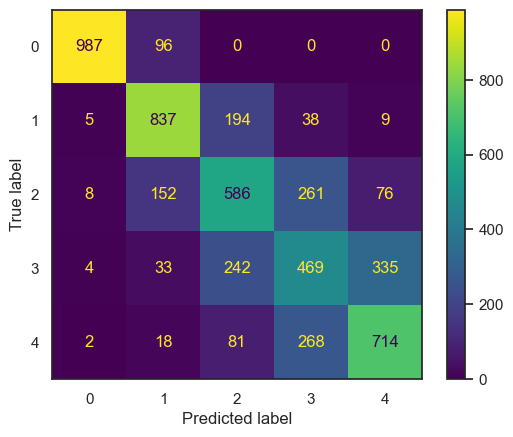

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      1083
           1       0.74      0.77      0.75      1083
           2       0.53      0.54      0.54      1083
           3       0.45      0.43      0.44      1083
           4       0.63      0.66      0.64      1083

    accuracy                           0.66      5415
   macro avg       0.67      0.66      0.66      5415
weighted avg       0.67      0.66      0.66      5415



In [ ]:
# source: https://github.com/cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline/blob/master/ResNet.py
# #!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Nov 12 01:09:17 2016

@author: stephen
"""

# ensures reproducability
seed_value= 42  
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)



def build_resnet_1d(input_shape, n_feature_maps, nb_classes):
    inputs = Input(shape=input_shape)

    # Block 1
    x = BatchNormalization()(inputs)
    x = Conv1D(n_feature_maps, 8, padding='same',kernel_initializer='he_normal' )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(n_feature_maps, 5, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(n_feature_maps, 3, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(n_feature_maps, 1, padding='same',kernel_initializer='he_normal')(inputs)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)

    # Block 2
    x1 = x
    x = Conv1D(n_feature_maps * 2, 8, padding='same',kernel_initializer='he_normal')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(n_feature_maps * 2, 5, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(n_feature_maps * 2, 3, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(n_feature_maps * 2, 1, padding='same',kernel_initializer='he_normal')(x1)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)

    # Block 3
    x1 = x
    x = Conv1D(n_feature_maps * 2, 8, padding='same',kernel_initializer='he_normal')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(n_feature_maps * 2, 5, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(n_feature_maps * 2, 3, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(n_feature_maps * 2, 1, padding='same',kernel_initializer='he_normal')(x1)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)

    # Output
    x = GlobalAveragePooling1D()(x)
    output = Dense(nb_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
    return model


# defines the early stopping callback
early_stopping = EarlyStopping(patience=5, monitor='val_loss', mode='min', verbose=1, restore_best_weights=True)

# initializes callbacks 
reduceLR =ReduceLROnPlateau(monitor='val_loss', patience=3, verbose= 1, mode='min', factor= 0.2, min_lr = 1e-5) 

checkpoint = ModelCheckpoint('CustomModel.weights.hdf5', monitor='val_loss', verbose=1,save_best_only=True, mode= 'min') 

callbacks= [early_stopping, checkpoint, reduceLR]

# initiliazes buffer size and batch size 
BUFFER_SIZE = len(X_train) 
BATCH_SIZE = 64

# reshapes Y_train, val, and test
Y_train_rs = Y_train.reshape(-1).astype('int32')
Y_val_rs = Y_val.reshape(-1).astype('int32')
Y_test_rs = Y_test.reshape(-1).astype('int32')

# converts train, val, and test data into tensors
X_train_t = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train_t = tf.convert_to_tensor(Y_train_rs, dtype=tf.int32)

X_val_t = tf.convert_to_tensor(X_val, dtype=tf.float32)
Y_val_t = tf.convert_to_tensor(Y_val_rs, dtype=tf.int32)

X_test_t = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_test_t = tf.convert_to_tensor(Y_test_rs, dtype=tf.int32)

# shuffles train data and applies batch size 
train_ds_t = tf.data.Dataset.from_tensor_slices((X_train_t, Y_train_t))
train_ds = train_ds_t.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# applies batch size to validation data 
val_ds = tf.data.Dataset.from_tensor_slices((X_val_t, Y_val_t)).batch(BATCH_SIZE)

# sets the learning rate of the Adam optimizer 
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

# builds and trains the model
model_wang_resnet3 = build_resnet_1d((X_train.shape[1], X_train.shape[2]), 64, 5) 
model_wang_resnet3.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['sparse_categorical_accuracy'])
model_wang_resnet3.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=callbacks, verbose=2)

sns.set_theme(style="white")
# evaluates the model and plots the confusion matrix
model_wang_resnet3.evaluate(X_test_t, Y_test_t)
predictions_model_wang_resnet3 = model_wang_resnet3.predict(X_test_t)
y_pred_model_wang_resnet3 = np.argmax(predictions_model_wang_resnet3, axis=1) 
ConfusionMatrixDisplay.from_predictions(
    Y_test_t, y_pred_model_wang_resnet3)
plt.show()

print(classification_report(Y_test_t, y_pred_model_wang_resnet3))

model_wang_resnet3.save("model_wang_resnet_SDBII.keras")